In [75]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -36]) # Column containing response actual values (temperature) at time t

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 5
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 22 weather station rows to train the scaling function
    dataset_testing = [] # Holds the remaining five weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training the scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + 12*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]


Model Parameters:
n_lag (number of input time steps): 20
n_seq (number of output/future prediction time steps): 5
C:\Users\User
C:\Users\User\Modeling\
     file_id  temperatures      slp  wet_bulb_temperature  specific_humidity  \
0       6678         20.84  1016.20                 18.08              12.82   
1       6678         20.69  1017.48                 17.71              12.33   
2       6678         20.47  1018.26                 17.29              12.14   
3       6678         20.30  1018.41                 17.20              11.90   
4       6678         20.46  1017.92                 17.75              12.75   
..       ...           ...      ...                   ...                ...   
643     8000         13.02  1016.94                  7.64               5.15   
644     8000         13.47  1016.16                  7.88               5.24   
645     8000         11.84  1017.90                  7.13               5.36   
646     8000         12.86  1016.17             

In [6]:
print(len(train[0]))
print(len(test[0]))
print(len(validation[0]))

19
2
3


In [13]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

5
21
(19, 0, 257)
(2, 0, 257)


[I 2025-06-04 20:17:41,984] A new study created in memory with name: no-name-fb68985f-eb58-43aa-8810-20fb71e22747
[I 2025-06-04 20:18:46,347] Trial 0 finished with value: 0.1579679161310196 and parameters: {'lr': 0.2548736820168725, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.24420634952419387}. Best is trial 0 with value: 0.1579679161310196.


Cross Validation Accuracies:
[0.17619983851909637, 0.15023905038833618, 0.14322228729724884, 0.16496334969997406, 0.1552150547504425]
Mean Cross Validation Accuracy:
0.1579679161310196
Standard Deviation of Cross Validation Accuracy:
0.011541977871534322


[I 2025-06-04 20:20:05,753] Trial 1 finished with value: 0.1022038146853447 and parameters: {'lr': 0.018302165065932137, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.22691119870166224}. Best is trial 1 with value: 0.1022038146853447.


Cross Validation Accuracies:
[0.15212994813919067, 0.0905105397105217, 0.10135584324598312, 0.0916978195309639, 0.07532492280006409]
Mean Cross Validation Accuracy:
0.1022038146853447
Standard Deviation of Cross Validation Accuracy:
0.02631699564925491


[I 2025-06-04 20:21:48,037] Trial 2 finished with value: 0.6017195105552673 and parameters: {'lr': 0.16890950891584544, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1155006155152333}. Best is trial 1 with value: 0.1022038146853447.


Cross Validation Accuracies:
[1.1425644159317017, 0.49341902136802673, 0.5402485132217407, 0.4918712079524994, 0.34049439430236816]
Mean Cross Validation Accuracy:
0.6017195105552673
Standard Deviation of Cross Validation Accuracy:
0.27868480478456953


[I 2025-06-04 20:22:46,541] Trial 3 finished with value: 0.23609517216682435 and parameters: {'lr': 0.006013517664053734, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.366067454344992}. Best is trial 1 with value: 0.1022038146853447.


Cross Validation Accuracies:
[0.24570831656455994, 0.1512024700641632, 0.25639182329177856, 0.3161810636520386, 0.21099218726158142]
Mean Cross Validation Accuracy:
0.23609517216682435
Standard Deviation of Cross Validation Accuracy:
0.05432319454620715


[I 2025-06-04 20:24:03,277] Trial 4 finished with value: 0.10046600699424743 and parameters: {'lr': 0.011426783171391282, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.27418238311097065}. Best is trial 4 with value: 0.10046600699424743.


Cross Validation Accuracies:
[0.14673450589179993, 0.08948386460542679, 0.106821708381176, 0.08660919964313507, 0.0726807564496994]
Mean Cross Validation Accuracy:
0.10046600699424743
Standard Deviation of Cross Validation Accuracy:
0.025557025020882623


[I 2025-06-04 20:25:59,821] Trial 5 finished with value: 6.089163017272949 and parameters: {'lr': 0.7255935746951006, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.48501977833738674}. Best is trial 4 with value: 0.10046600699424743.


Cross Validation Accuracies:
[8.188937187194824, 5.346156120300293, 4.787191390991211, 5.898252964019775, 6.225277423858643]
Mean Cross Validation Accuracy:
6.089163017272949
Standard Deviation of Cross Validation Accuracy:
1.1585520885463938


[I 2025-06-04 20:27:00,357] Trial 6 finished with value: 0.09898791462182999 and parameters: {'lr': 0.06277395517454439, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1271416630787132}. Best is trial 6 with value: 0.09898791462182999.


Cross Validation Accuracies:
[0.14271430671215057, 0.08402059227228165, 0.10518936067819595, 0.08970681577920914, 0.07330849766731262]
Mean Cross Validation Accuracy:
0.09898791462182999
Standard Deviation of Cross Validation Accuracy:
0.024166287623845782


[I 2025-06-04 20:28:10,512] Trial 7 finished with value: 0.09809504896402359 and parameters: {'lr': 0.015646684140218022, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3652784842982497}. Best is trial 7 with value: 0.09809504896402359.


Cross Validation Accuracies:
[0.1436982899904251, 0.08927282691001892, 0.1047714352607727, 0.08139798045158386, 0.07133471220731735]
Mean Cross Validation Accuracy:
0.09809504896402359
Standard Deviation of Cross Validation Accuracy:
0.02528623755447649


[I 2025-06-04 20:30:26,484] Trial 8 finished with value: 0.3744128465652466 and parameters: {'lr': 0.23431920323154143, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.26228825572974196}. Best is trial 7 with value: 0.09809504896402359.


Cross Validation Accuracies:
[0.1878395825624466, 1.2165595293045044, 0.2035723328590393, 0.14012686908245087, 0.12396591901779175]
Mean Cross Validation Accuracy:
0.3744128465652466
Standard Deviation of Cross Validation Accuracy:
0.4220949376564056


[I 2025-06-04 20:31:45,719] Trial 9 finished with value: 0.1005217745900154 and parameters: {'lr': 0.45908862466551287, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.44502386920901194}. Best is trial 7 with value: 0.09809504896402359.


Cross Validation Accuracies:
[0.15602236986160278, 0.08628007024526596, 0.10115421563386917, 0.0822749212384224, 0.07687729597091675]
Mean Cross Validation Accuracy:
0.1005217745900154
Standard Deviation of Cross Validation Accuracy:
0.028898274087638207


[I 2025-06-04 20:32:54,516] Trial 10 finished with value: 0.09665607959032059 and parameters: {'lr': 0.001698581689068802, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3727336044437487}. Best is trial 10 with value: 0.09665607959032059.


Cross Validation Accuracies:
[0.14419245719909668, 0.08707401901483536, 0.10082338750362396, 0.07993781566619873, 0.0712527185678482]
Mean Cross Validation Accuracy:
0.09665607959032059
Standard Deviation of Cross Validation Accuracy:
0.025666011128164662


[I 2025-06-04 20:34:15,169] Trial 11 finished with value: 0.23537104576826096 and parameters: {'lr': 0.0011211965856422457, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3713637153579019}. Best is trial 10 with value: 0.09665607959032059.


Cross Validation Accuracies:
[0.36684510111808777, 0.08742593973875046, 0.10068659484386444, 0.14623405039310455, 0.47566354274749756]
Mean Cross Validation Accuracy:
0.23537104576826096
Standard Deviation of Cross Validation Accuracy:
0.1568432153445253


[I 2025-06-04 20:35:14,008] Trial 12 finished with value: 0.09666166454553604 and parameters: {'lr': 0.0018224755784567563, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.39451961835057303}. Best is trial 10 with value: 0.09665607959032059.


Cross Validation Accuracies:
[0.14471721649169922, 0.08579254150390625, 0.10175053775310516, 0.07982627302408218, 0.07122175395488739]
Mean Cross Validation Accuracy:
0.09666166454553604
Standard Deviation of Cross Validation Accuracy:
0.02601534161839136


[I 2025-06-04 20:36:12,510] Trial 13 finished with value: 0.09632550925016403 and parameters: {'lr': 0.0012958444605621683, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.43333321457983764}. Best is trial 13 with value: 0.09632550925016403.


Cross Validation Accuracies:
[0.14353854954242706, 0.09120248258113861, 0.10148880630731583, 0.07449265569448471, 0.07090505212545395]
Mean Cross Validation Accuracy:
0.09632550925016403
Standard Deviation of Cross Validation Accuracy:
0.026095399392244423


[I 2025-06-04 20:37:12,281] Trial 14 finished with value: 0.09748123586177826 and parameters: {'lr': 0.0032696669563716677, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4423187325739876}. Best is trial 13 with value: 0.09632550925016403.


Cross Validation Accuracies:
[0.1447407603263855, 0.08750050514936447, 0.10270733386278152, 0.08225337415933609, 0.07020420581102371]
Mean Cross Validation Accuracy:
0.09748123586177826
Standard Deviation of Cross Validation Accuracy:
0.025831429998778976


[I 2025-06-04 20:38:14,372] Trial 15 finished with value: 0.16345761716365814 and parameters: {'lr': 0.0031199730934831026, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.3080336481933407}. Best is trial 13 with value: 0.09632550925016403.


Cross Validation Accuracies:
[0.2689809501171112, 0.1716049611568451, 0.14647865295410156, 0.11867810040712357, 0.11154542118310928]
Mean Cross Validation Accuracy:
0.16345761716365814
Standard Deviation of Cross Validation Accuracy:
0.05690328540576495


[I 2025-06-04 20:39:07,866] Trial 16 finished with value: 0.2987643346190453 and parameters: {'lr': 0.0010458163974329192, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.49626590483005717}. Best is trial 13 with value: 0.09632550925016403.


Cross Validation Accuracies:
[0.2565900981426239, 0.7613149285316467, 0.21406613290309906, 0.19002002477645874, 0.07183048874139786]
Mean Cross Validation Accuracy:
0.2987643346190453
Standard Deviation of Cross Validation Accuracy:
0.23926127929656515


[I 2025-06-04 20:40:01,779] Trial 17 finished with value: 0.17732891887426377 and parameters: {'lr': 0.0530455667949822, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4261849583553419}. Best is trial 13 with value: 0.09632550925016403.


Cross Validation Accuracies:
[0.10922030359506607, 0.2213161140680313, 0.15119968354701996, 0.20237210392951965, 0.20253638923168182]
Mean Cross Validation Accuracy:
0.17732891887426377
Standard Deviation of Cross Validation Accuracy:
0.04127704309802909


[I 2025-06-04 20:41:02,104] Trial 18 finished with value: 0.11124455779790879 and parameters: {'lr': 0.00566287164339286, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.32994745473477466}. Best is trial 13 with value: 0.09632550925016403.


Cross Validation Accuracies:
[0.13353712856769562, 0.12329677492380142, 0.10405325889587402, 0.11575790494680405, 0.0795777216553688]
Mean Cross Validation Accuracy:
0.11124455779790879
Standard Deviation of Cross Validation Accuracy:
0.018531531198683705


[I 2025-06-04 20:42:08,876] Trial 19 finished with value: 0.1861196905374527 and parameters: {'lr': 0.0027474031487139832, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.4119122348244036}. Best is trial 13 with value: 0.09632550925016403.


Cross Validation Accuracies:
[0.2657582759857178, 0.22236615419387817, 0.1483052372932434, 0.13749070465564728, 0.15667808055877686]
Mean Cross Validation Accuracy:
0.1861196905374527
Standard Deviation of Cross Validation Accuracy:
0.049633919772641324


[I 2025-06-04 20:43:13,867] Trial 20 finished with value: 0.09609388262033462 and parameters: {'lr': 0.00690254467501205, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1819752113031357}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.14298656582832336, 0.08653944730758667, 0.10081083327531815, 0.08034215122461319, 0.06979041546583176]
Mean Cross Validation Accuracy:
0.09609388262033462
Standard Deviation of Cross Validation Accuracy:
0.02550470553597038


[I 2025-06-04 20:44:15,546] Trial 21 finished with value: 0.09695971608161927 and parameters: {'lr': 0.0059940114829238975, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.18181889513317806}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.14388015866279602, 0.08693771809339523, 0.10144804418087006, 0.08101064711809158, 0.07152201235294342]
Mean Cross Validation Accuracy:
0.09695971608161927
Standard Deviation of Cross Validation Accuracy:
0.025391191530163552


[I 2025-06-04 20:45:15,832] Trial 22 finished with value: 0.09653527438640594 and parameters: {'lr': 0.0019971445798200615, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.19702439627218876}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.14362598955631256, 0.08646523207426071, 0.10117638856172562, 0.08038449287414551, 0.07102426886558533]
Mean Cross Validation Accuracy:
0.09653527438640594
Standard Deviation of Cross Validation Accuracy:
0.025503491111258218


[I 2025-06-04 20:46:11,474] Trial 23 finished with value: 0.09658022820949555 and parameters: {'lr': 0.006852814435402105, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.18031073724557728}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.14443106949329376, 0.08732135593891144, 0.10006677359342575, 0.08048826456069946, 0.07059367746114731]
Mean Cross Validation Accuracy:
0.09658022820949555
Standard Deviation of Cross Validation Accuracy:
0.025775328668612926


[I 2025-06-04 20:47:06,103] Trial 24 finished with value: 0.09658405184745789 and parameters: {'lr': 0.0019588466012259343, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.19554762583214902}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.1426943689584732, 0.08723010867834091, 0.10117171704769135, 0.08049258589744568, 0.07133147865533829]
Mean Cross Validation Accuracy:
0.09658405184745789
Standard Deviation of Cross Validation Accuracy:
0.025025315175328584


[I 2025-06-04 20:48:02,153] Trial 25 finished with value: 0.09635353684425355 and parameters: {'lr': 0.003572714461984668, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.14324497418805976}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.14281171560287476, 0.08655858039855957, 0.10121366381645203, 0.07994932681322098, 0.07123439759016037]
Mean Cross Validation Accuracy:
0.09635353684425355
Standard Deviation of Cross Validation Accuracy:
0.025211083448101513


[I 2025-06-04 20:49:01,242] Trial 26 finished with value: 0.1071693703532219 and parameters: {'lr': 0.02627910790663898, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.14777755401977796}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.1585037261247635, 0.10662350803613663, 0.10630158334970474, 0.08186835795640945, 0.08254967629909515]
Mean Cross Validation Accuracy:
0.1071693703532219
Standard Deviation of Cross Validation Accuracy:
0.027865884755572907


[I 2025-06-04 20:50:14,539] Trial 27 finished with value: 0.22880819439888 and parameters: {'lr': 0.009531295273263145, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.14264333726031408}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.15781129896640778, 0.2897554934024811, 0.1943066269159317, 0.2623620927333832, 0.2398054599761963]
Mean Cross Validation Accuracy:
0.22880819439888
Standard Deviation of Cross Validation Accuracy:
0.047312354664050246


[I 2025-06-04 20:51:13,796] Trial 28 finished with value: 0.09800784438848495 and parameters: {'lr': 0.004654271386240413, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.10146911750751378}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.1352788507938385, 0.08447650820016861, 0.109346903860569, 0.08604434132575989, 0.07489261776208878]
Mean Cross Validation Accuracy:
0.09800784438848495
Standard Deviation of Cross Validation Accuracy:
0.02180934824675919


[I 2025-06-04 20:52:48,830] Trial 29 finished with value: 0.09641646146774292 and parameters: {'lr': 0.003850336847596983, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.21767121002789985}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.1430239975452423, 0.08636816591024399, 0.10129699110984802, 0.08026473969221115, 0.07112841308116913]
Mean Cross Validation Accuracy:
0.09641646146774292
Standard Deviation of Cross Validation Accuracy:
0.025287996124365456


[I 2025-06-04 20:54:06,203] Trial 30 finished with value: 0.10593218505382537 and parameters: {'lr': 0.043501412043309526, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.1536723464397123}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.15443795919418335, 0.0948890820145607, 0.10598552227020264, 0.08951940387487411, 0.08482895791530609]
Mean Cross Validation Accuracy:
0.10593218505382537
Standard Deviation of Cross Validation Accuracy:
0.025256637449343734


[I 2025-06-04 20:55:38,986] Trial 31 finished with value: 0.0965267390012741 and parameters: {'lr': 0.003506621335971516, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.22457582914157065}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.14345264434814453, 0.0866718739271164, 0.10112302005290985, 0.08021710067987442, 0.07116905599832535]
Mean Cross Validation Accuracy:
0.0965267390012741
Standard Deviation of Cross Validation Accuracy:
0.025413780306014398


[I 2025-06-04 20:57:11,870] Trial 32 finished with value: 0.09667515605688096 and parameters: {'lr': 0.010235286111121579, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.22428617659480332}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.14367781579494476, 0.08641654253005981, 0.10090742260217667, 0.081650510430336, 0.07072348892688751]
Mean Cross Validation Accuracy:
0.09667515605688096
Standard Deviation of Cross Validation Accuracy:
0.025422943405847206


[I 2025-06-04 20:58:36,101] Trial 33 finished with value: 0.22975738644599913 and parameters: {'lr': 0.09139318567989267, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.24706068014043803}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.20230592787265778, 0.27680763602256775, 0.19804425537586212, 0.22323882579803467, 0.2483902871608734]
Mean Cross Validation Accuracy:
0.22975738644599913
Standard Deviation of Cross Validation Accuracy:
0.029538814692754732


[I 2025-06-04 21:00:02,347] Trial 34 finished with value: 0.10229501575231552 and parameters: {'lr': 0.020627543665374313, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.16644684272960772}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.1422477513551712, 0.10871639102697372, 0.10176172107458115, 0.07393839955329895, 0.08481081575155258]
Mean Cross Validation Accuracy:
0.10229501575231552
Standard Deviation of Cross Validation Accuracy:
0.023441563419311397


[I 2025-06-04 21:01:47,816] Trial 35 finished with value: 0.132927605509758 and parameters: {'lr': 0.0014160190176237641, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.28862495393426046}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.14036832749843597, 0.08816862106323242, 0.28542429208755493, 0.07939758151769638, 0.07127920538187027]
Mean Cross Validation Accuracy:
0.132927605509758
Standard Deviation of Cross Validation Accuracy:
0.07997494502220404


[I 2025-06-04 21:04:02,519] Trial 36 finished with value: 0.15300098955631256 and parameters: {'lr': 0.0024299168257419495, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2194151163808285}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.20350119471549988, 0.1377403438091278, 0.12907177209854126, 0.16674742102622986, 0.127944216132164]
Mean Cross Validation Accuracy:
0.15300098955631256
Standard Deviation of Cross Validation Accuracy:
0.028887962027351926


[I 2025-06-04 21:05:07,935] Trial 37 finished with value: 0.1068483129143715 and parameters: {'lr': 0.004333704829510351, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3309463594001648}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.137269988656044, 0.11838633567094803, 0.11872000247240067, 0.08898717164993286, 0.07087806612253189]
Mean Cross Validation Accuracy:
0.1068483129143715
Standard Deviation of Cross Validation Accuracy:
0.0237167466510862


[I 2025-06-04 21:06:36,044] Trial 38 finished with value: 0.09655612707138062 and parameters: {'lr': 0.007976841559441561, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.11285814523441426}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.14470961689949036, 0.08593285828828812, 0.10066115856170654, 0.0802374854683876, 0.07123951613903046]
Mean Cross Validation Accuracy:
0.09655612707138062
Standard Deviation of Cross Validation Accuracy:
0.0259063411490978


[I 2025-06-04 21:08:11,469] Trial 39 finished with value: 0.09651770293712617 and parameters: {'lr': 0.012701911901524856, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.12876411364913354}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.14327967166900635, 0.08501072227954865, 0.10137367248535156, 0.08068646490573883, 0.07223798334598541]
Mean Cross Validation Accuracy:
0.09651770293712617
Standard Deviation of Cross Validation Accuracy:
0.025230163078424062


[I 2025-06-04 21:09:31,757] Trial 40 finished with value: 0.34370445609092715 and parameters: {'lr': 0.0042085492453016815, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.25010852905196146}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.3453345000743866, 0.27164193987846375, 0.36188167333602905, 0.31377384066581726, 0.42589032649993896]
Mean Cross Validation Accuracy:
0.34370445609092715
Standard Deviation of Cross Validation Accuracy:
0.05133504367904619


[I 2025-06-04 21:10:33,124] Trial 41 finished with value: 0.09675839841365814 and parameters: {'lr': 0.014185851797739015, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.13083764479330404}. Best is trial 20 with value: 0.09609388262033462.


Cross Validation Accuracies:
[0.14446744322776794, 0.08628062158823013, 0.1003836989402771, 0.08007486909627914, 0.07258535921573639]
Mean Cross Validation Accuracy:
0.09675839841365814
Standard Deviation of Cross Validation Accuracy:
0.025541164980222117


[I 2025-06-04 21:11:40,400] Trial 42 finished with value: 0.09607883542776108 and parameters: {'lr': 0.017297460108067854, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.12775198153508777}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.14504584670066833, 0.08696039766073227, 0.10147526860237122, 0.08006127923727036, 0.06685138493776321]
Mean Cross Validation Accuracy:
0.09607883542776108
Standard Deviation of Cross Validation Accuracy:
0.026910375544689228


[I 2025-06-04 21:12:33,459] Trial 43 finished with value: 0.11374440342187882 and parameters: {'lr': 0.02661545941806538, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.20119207518608465}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.1307268887758255, 0.06684226542711258, 0.1303844451904297, 0.12410583347082138, 0.11666258424520493]
Mean Cross Validation Accuracy:
0.11374440342187882
Standard Deviation of Cross Validation Accuracy:
0.02400408864886557


[I 2025-06-04 21:13:28,200] Trial 44 finished with value: 0.09772240221500397 and parameters: {'lr': 0.017127305458592004, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.16480991211876428}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.14457643032073975, 0.08646538108587265, 0.10131476074457169, 0.08181249350309372, 0.07444294542074203]
Mean Cross Validation Accuracy:
0.09772240221500397
Standard Deviation of Cross Validation Accuracy:
0.02501992733041793


[I 2025-06-04 21:14:29,578] Trial 45 finished with value: 0.2515201404690742 and parameters: {'lr': 0.001433156365355548, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.10227789130725976}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.2743837535381317, 0.08653122186660767, 0.3827105164527893, 0.4211726784706116, 0.09280253201723099]
Mean Cross Validation Accuracy:
0.2515201404690742
Standard Deviation of Cross Validation Accuracy:
0.14066148420798574


[I 2025-06-04 21:16:01,223] Trial 46 finished with value: 0.09831615835428238 and parameters: {'lr': 0.002414450098242043, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.16820410535549085}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.14248579740524292, 0.08411385864019394, 0.09840288013219833, 0.0851704552769661, 0.08140780031681061]
Mean Cross Validation Accuracy:
0.09831615835428238
Standard Deviation of Cross Validation Accuracy:
0.02285332331477415


[I 2025-06-04 21:17:23,547] Trial 47 finished with value: 0.16179269105195998 and parameters: {'lr': 0.009182623103948045, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.47334598200962974}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.22019007802009583, 0.2290065884590149, 0.15918564796447754, 0.09352253377437592, 0.10705860704183578]
Mean Cross Validation Accuracy:
0.16179269105195998
Standard Deviation of Cross Validation Accuracy:
0.0558415504980757


[I 2025-06-04 21:18:45,170] Trial 48 finished with value: 3.0858033418655397 and parameters: {'lr': 0.1293630207451502, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2746806522360735}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[5.5046868324279785, 0.6288585662841797, 2.510220766067505, 4.84334659576416, 1.9419039487838745]
Mean Cross Validation Accuracy:
3.0858033418655397
Standard Deviation of Cross Validation Accuracy:
1.822982961168399


[I 2025-06-04 21:20:02,964] Trial 49 finished with value: 0.1349144384264946 and parameters: {'lr': 0.03708544947972483, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.14197124929831612}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.13966181874275208, 0.06432916969060898, 0.19724448025226593, 0.16260895133018494, 0.11072777211666107]
Mean Cross Validation Accuracy:
0.1349144384264946
Standard Deviation of Cross Validation Accuracy:
0.04525888369931961


[I 2025-06-04 21:21:17,986] Trial 50 finished with value: 0.13111076056957244 and parameters: {'lr': 0.0013822707864792427, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.11692354959044057}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.14323656260967255, 0.08662671595811844, 0.27328014373779297, 0.08008655160665512, 0.07232382893562317]
Mean Cross Validation Accuracy:
0.13111076056957244
Standard Deviation of Cross Validation Accuracy:
0.07536228770647546


[I 2025-06-04 21:22:21,072] Trial 51 finished with value: 0.0965968281030655 and parameters: {'lr': 0.012874227402168745, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.12728385706273282}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.14563702046871185, 0.08682595193386078, 0.10054872184991837, 0.07930833101272583, 0.07066411525011063]
Mean Cross Validation Accuracy:
0.0965968281030655
Standard Deviation of Cross Validation Accuracy:
0.026409943885273367


[I 2025-06-04 21:23:35,480] Trial 52 finished with value: 0.09632810205221176 and parameters: {'lr': 0.006712895843642019, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.20967518895069154}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.14303378760814667, 0.08690475672483444, 0.1014048233628273, 0.07987000793218613, 0.07042713463306427]
Mean Cross Validation Accuracy:
0.09632810205221176
Standard Deviation of Cross Validation Accuracy:
0.0254468959796117


[I 2025-06-04 21:24:56,394] Trial 53 finished with value: 0.09628060311079026 and parameters: {'lr': 0.0052800884349118865, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.20881604863062903}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.14403589069843292, 0.0863196849822998, 0.10037153214216232, 0.08012876659631729, 0.07054714113473892]
Mean Cross Validation Accuracy:
0.09628060311079026
Standard Deviation of Cross Validation Accuracy:
0.02576670708858162


[I 2025-06-04 21:26:00,372] Trial 54 finished with value: 0.0966462716460228 and parameters: {'lr': 0.005569231081221397, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.18504084041097613}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.14337308704853058, 0.086625836789608, 0.10088033229112625, 0.08079198002815247, 0.07156012207269669]
Mean Cross Validation Accuracy:
0.0966462716460228
Standard Deviation of Cross Validation Accuracy:
0.025228575564378852


[I 2025-06-04 21:27:02,909] Trial 55 finished with value: 0.09741108864545822 and parameters: {'lr': 0.006773727151321658, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.20420548821804327}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.14402151107788086, 0.08792807161808014, 0.1017516627907753, 0.08155406266450882, 0.07180013507604599]
Mean Cross Validation Accuracy:
0.09741108864545822
Standard Deviation of Cross Validation Accuracy:
0.02525337953968347


[I 2025-06-04 21:28:05,854] Trial 56 finished with value: 0.12446857690811157 and parameters: {'lr': 0.9939437271268591, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2409191922686156}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.1371532529592514, 0.12182594835758209, 0.14487335085868835, 0.098636694252491, 0.11985363811254501]
Mean Cross Validation Accuracy:
0.12446857690811157
Standard Deviation of Cross Validation Accuracy:
0.015955081408586716


[I 2025-06-04 21:29:12,562] Trial 57 finished with value: 0.11220882385969162 and parameters: {'lr': 0.021467130289707217, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.15730625231464285}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.16490031778812408, 0.11477502435445786, 0.09892759472131729, 0.10257495939731598, 0.07986622303724289]
Mean Cross Validation Accuracy:
0.11220882385969162
Standard Deviation of Cross Validation Accuracy:
0.028629443366070054


[I 2025-06-04 21:30:17,821] Trial 58 finished with value: 0.09770727902650833 and parameters: {'lr': 0.005409091214722654, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.3143776377891392}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.1436700075864792, 0.08474858105182648, 0.09384369850158691, 0.08451098948717117, 0.0817631185054779]
Mean Cross Validation Accuracy:
0.09770727902650833
Standard Deviation of Cross Validation Accuracy:
0.023340033576134976


[I 2025-06-04 21:31:22,797] Trial 59 finished with value: 0.259824600815773 and parameters: {'lr': 0.008215306260854696, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.18117741110104718}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.2798098027706146, 0.2136877179145813, 0.23644353449344635, 0.2733277976512909, 0.2958541512489319]
Mean Cross Validation Accuracy:
0.259824600815773
Standard Deviation of Cross Validation Accuracy:
0.030183304499598444


[I 2025-06-04 21:32:20,135] Trial 60 finished with value: 0.09659446626901627 and parameters: {'lr': 0.002452126786262541, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.46132252269849683}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.1439616084098816, 0.08588584512472153, 0.1006116271018982, 0.08095472306013107, 0.07155852764844894]
Mean Cross Validation Accuracy:
0.09659446626901627
Standard Deviation of Cross Validation Accuracy:
0.02547884649200156


[I 2025-06-04 21:33:16,506] Trial 61 finished with value: 0.0965800255537033 and parameters: {'lr': 0.0036112196364862853, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.20704841272786062}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.14373068511486053, 0.08679711073637009, 0.10134688764810562, 0.0799296572804451, 0.0710957869887352]
Mean Cross Validation Accuracy:
0.0965800255537033
Standard Deviation of Cross Validation Accuracy:
0.025566752912615738


[I 2025-06-04 21:34:10,383] Trial 62 finished with value: 0.09669119268655776 and parameters: {'lr': 0.0031661433157771563, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.23909071741738153}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.14354611933231354, 0.08657617121934891, 0.10177885740995407, 0.08032191544771194, 0.07123290002346039]
Mean Cross Validation Accuracy:
0.09669119268655776
Standard Deviation of Cross Validation Accuracy:
0.025454508619264505


[I 2025-06-04 21:35:03,328] Trial 63 finished with value: 0.09677931517362595 and parameters: {'lr': 0.004709541048270253, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.21268432492860845}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.14418156445026398, 0.08589785546064377, 0.10216421633958817, 0.07993636280298233, 0.07171657681465149]
Mean Cross Validation Accuracy:
0.09677931517362595
Standard Deviation of Cross Validation Accuracy:
0.025714596870832506


[I 2025-06-04 21:36:31,161] Trial 64 finished with value: 0.09625615030527115 and parameters: {'lr': 0.0073531357416226715, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.26603450230988374}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.143071711063385, 0.08673647046089172, 0.10197646170854568, 0.07893010228872299, 0.07056600600481033]
Mean Cross Validation Accuracy:
0.09625615030527115
Standard Deviation of Cross Validation Accuracy:
0.02559382132483072


[I 2025-06-04 21:37:22,028] Trial 65 finished with value: 0.09657457321882248 and parameters: {'lr': 0.007424008841963246, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.26427704602305474}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.1436806470155716, 0.08639100193977356, 0.10091739147901535, 0.08102583140134811, 0.07085799425840378]
Mean Cross Validation Accuracy:
0.09657457321882248
Standard Deviation of Cross Validation Accuracy:
0.025474117015179286


[I 2025-06-04 21:38:13,353] Trial 66 finished with value: 0.09735038578510284 and parameters: {'lr': 0.009336714901257658, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3807588765687208}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.1433579921722412, 0.087543785572052, 0.10347075015306473, 0.08134149760007858, 0.0710379034280777]
Mean Cross Validation Accuracy:
0.09735038578510284
Standard Deviation of Cross Validation Accuracy:
0.02529410738460027


[I 2025-06-04 21:39:04,420] Trial 67 finished with value: 0.11790314912796021 and parameters: {'lr': 0.3595258213093703, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.19054235948405024}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.1544574499130249, 0.10394174605607986, 0.13183900713920593, 0.11196335405111313, 0.0873141884803772]
Mean Cross Validation Accuracy:
0.11790314912796021
Standard Deviation of Cross Validation Accuracy:
0.023222021872284986


[I 2025-06-04 21:40:24,060] Trial 68 finished with value: 0.3201499104499817 and parameters: {'lr': 0.0010934339888690665, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.2906316711111172}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.23451030254364014, 0.3649950325489044, 0.34217095375061035, 0.3116230368614197, 0.34745022654533386]
Mean Cross Validation Accuracy:
0.3201499104499817
Standard Deviation of Cross Validation Accuracy:
0.046147954664467694


[I 2025-06-04 21:41:21,353] Trial 69 finished with value: 0.09717216789722442 and parameters: {'lr': 0.011631623351617553, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.17382094903090003}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.14778059720993042, 0.08233807235956192, 0.10481958836317062, 0.08335749059915543, 0.06756509095430374]
Mean Cross Validation Accuracy:
0.09717216789722442
Standard Deviation of Cross Validation Accuracy:
0.02795414409942268


[I 2025-06-04 21:42:46,522] Trial 70 finished with value: 0.09620161950588227 and parameters: {'lr': 0.006657770192741146, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3306073310286494}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.14289557933807373, 0.08550810068845749, 0.10181362181901932, 0.07950004190206528, 0.0712907537817955]
Mean Cross Validation Accuracy:
0.09620161950588227
Standard Deviation of Cross Validation Accuracy:
0.02539947135296869


[I 2025-06-04 21:44:14,311] Trial 71 finished with value: 0.09697005152702332 and parameters: {'lr': 0.006300012236421832, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.23137464540646044}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.14430628716945648, 0.08724876493215561, 0.10191643983125687, 0.07994414120912552, 0.0714346244931221]
Mean Cross Validation Accuracy:
0.09697005152702332
Standard Deviation of Cross Validation Accuracy:
0.02569680536980644


[I 2025-06-04 21:45:39,176] Trial 72 finished with value: 0.0963228777050972 and parameters: {'lr': 0.0048918143872962875, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.34188584817381884}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.1423933207988739, 0.08524680882692337, 0.10093357414007187, 0.08153229206800461, 0.07150839269161224]
Mean Cross Validation Accuracy:
0.0963228777050972
Standard Deviation of Cross Validation Accuracy:
0.02490358865801913


[I 2025-06-04 21:47:09,697] Trial 73 finished with value: 0.09794561117887497 and parameters: {'lr': 0.017450095174860795, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3464867433136949}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.1411590725183487, 0.08373399078845978, 0.09996707737445831, 0.08717669546604156, 0.0776912197470665]
Mean Cross Validation Accuracy:
0.09794561117887497
Standard Deviation of Cross Validation Accuracy:
0.02280205972513171


[I 2025-06-04 21:48:38,214] Trial 74 finished with value: 0.09619212448596955 and parameters: {'lr': 0.004904426425281747, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.34974178333143613}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.14357568323612213, 0.08579542487859726, 0.10070811212062836, 0.08065749704837799, 0.07022390514612198]
Mean Cross Validation Accuracy:
0.09619212448596955
Standard Deviation of Cross Validation Accuracy:
0.025649016402890357


[I 2025-06-04 21:50:05,991] Trial 75 finished with value: 0.09662978500127792 and parameters: {'lr': 0.00466472715095904, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3487242515348032}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.14451222121715546, 0.08723675459623337, 0.10112544894218445, 0.0796440988779068, 0.07063040137290955]
Mean Cross Validation Accuracy:
0.09662978500127792
Standard Deviation of Cross Validation Accuracy:
0.025944745882602094


[I 2025-06-04 21:51:58,125] Trial 76 finished with value: 0.15924447774887085 and parameters: {'lr': 0.002909996194455086, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.40331642668818823}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.20036977529525757, 0.14520101249217987, 0.19056104123592377, 0.1537855714559555, 0.10630498826503754]
Mean Cross Validation Accuracy:
0.15924447774887085
Standard Deviation of Cross Validation Accuracy:
0.03376869961386453


[I 2025-06-04 21:53:51,296] Trial 77 finished with value: 0.09720946550369262 and parameters: {'lr': 0.01049340321480478, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.31019683139691706}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.14503924548625946, 0.08552408963441849, 0.10198798030614853, 0.08186736702919006, 0.0716286450624466]
Mean Cross Validation Accuracy:
0.09720946550369262
Standard Deviation of Cross Validation Accuracy:
0.02583342186452604


[I 2025-06-04 21:55:35,916] Trial 78 finished with value: 0.4991136610507965 and parameters: {'lr': 0.0019727461372449286, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.35345266304404144}. Best is trial 42 with value: 0.09607883542776108.


Cross Validation Accuracies:
[0.42274776101112366, 0.5424851179122925, 0.4841698408126831, 0.53486168384552, 0.5113039016723633]
Mean Cross Validation Accuracy:
0.4991136610507965
Standard Deviation of Cross Validation Accuracy:
0.043272797049903604


[I 2025-06-04 21:57:28,315] Trial 79 finished with value: 0.09602738320827484 and parameters: {'lr': 0.0052736659724981145, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.32203614789057217}. Best is trial 79 with value: 0.09602738320827484.


Cross Validation Accuracies:
[0.14248058199882507, 0.08704439550638199, 0.10012839734554291, 0.07992766797542572, 0.07055587321519852]
Mean Cross Validation Accuracy:
0.09602738320827484
Standard Deviation of Cross Validation Accuracy:
0.025153173616015254


[I 2025-06-04 21:59:28,391] Trial 80 finished with value: 0.0966599553823471 and parameters: {'lr': 0.005265741651182646, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3266206150967551}. Best is trial 79 with value: 0.09602738320827484.


Cross Validation Accuracies:
[0.14418688416481018, 0.08650640398263931, 0.10196514427661896, 0.07963377237319946, 0.07100757211446762]
Mean Cross Validation Accuracy:
0.0966599553823471
Standard Deviation of Cross Validation Accuracy:
0.025837895695690477


[I 2025-06-04 22:02:31,148] Trial 81 finished with value: 0.09649322032928467 and parameters: {'lr': 0.007788606202612185, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2976406300692039}. Best is trial 79 with value: 0.09602738320827484.


Cross Validation Accuracies:
[0.1437806487083435, 0.08603935688734055, 0.10158947110176086, 0.08030448853969574, 0.07075213640928268]
Mean Cross Validation Accuracy:
0.09649322032928467
Standard Deviation of Cross Validation Accuracy:
0.025675024260301025


[I 2025-06-04 22:04:41,721] Trial 82 finished with value: 0.09628891944885254 and parameters: {'lr': 0.015245639460308215, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.38615716649913734}. Best is trial 79 with value: 0.09602738320827484.


Cross Validation Accuracies:
[0.14734548330307007, 0.0814918503165245, 0.10060624033212662, 0.07947734743356705, 0.07252367585897446]
Mean Cross Validation Accuracy:
0.09628891944885254
Standard Deviation of Cross Validation Accuracy:
0.027172710514879492


[I 2025-06-04 22:07:04,359] Trial 83 finished with value: 0.10307891368865967 and parameters: {'lr': 0.022001326916229788, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.362370089200254}. Best is trial 79 with value: 0.09602738320827484.


Cross Validation Accuracies:
[0.14097349345684052, 0.08989451080560684, 0.10233195871114731, 0.0981588363647461, 0.08403576910495758]
Mean Cross Validation Accuracy:
0.10307891368865967
Standard Deviation of Cross Validation Accuracy:
0.01998616578254656


[I 2025-06-04 22:09:28,395] Trial 84 finished with value: 0.09675571769475937 and parameters: {'lr': 0.014259598311419111, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.38754046800590464}. Best is trial 79 with value: 0.09602738320827484.


Cross Validation Accuracies:
[0.1455199122428894, 0.08434896171092987, 0.10170962661504745, 0.08176422864198685, 0.07043585926294327]
Mean Cross Validation Accuracy:
0.09675571769475937
Standard Deviation of Cross Validation Accuracy:
0.02635866145862082


[I 2025-06-04 22:11:32,471] Trial 85 finished with value: 0.11284453421831131 and parameters: {'lr': 0.028064204631879953, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3331937567807929}. Best is trial 79 with value: 0.09602738320827484.


Cross Validation Accuracies:
[0.11955119669437408, 0.09629257768392563, 0.10911168903112411, 0.1221618801355362, 0.11710532754659653]
Mean Cross Validation Accuracy:
0.11284453421831131
Standard Deviation of Cross Validation Accuracy:
0.009357863159964619


[I 2025-06-04 22:13:33,275] Trial 86 finished with value: 0.09629980623722076 and parameters: {'lr': 0.003869111613975153, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.31892429583955145}. Best is trial 79 with value: 0.09602738320827484.


Cross Validation Accuracies:
[0.14362603425979614, 0.08520153164863586, 0.10087946057319641, 0.07979509234428406, 0.07199691236019135]
Mean Cross Validation Accuracy:
0.09629980623722076
Standard Deviation of Cross Validation Accuracy:
0.0254831435384699


[I 2025-06-04 22:15:40,691] Trial 87 finished with value: 0.09652947336435318 and parameters: {'lr': 0.008744880649181625, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2741335426356818}. Best is trial 79 with value: 0.09602738320827484.


Cross Validation Accuracies:
[0.14390452206134796, 0.08585498481988907, 0.10116317868232727, 0.07987505942583084, 0.07184962183237076]
Mean Cross Validation Accuracy:
0.09652947336435318
Standard Deviation of Cross Validation Accuracy:
0.025558856566672485


[I 2025-06-04 22:17:45,051] Trial 88 finished with value: 0.09918403178453446 and parameters: {'lr': 0.003959887047586099, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3124371649793289}. Best is trial 79 with value: 0.09602738320827484.


Cross Validation Accuracies:
[0.14370127022266388, 0.09027662128210068, 0.10702815651893616, 0.08398435264825821, 0.07092975825071335]
Mean Cross Validation Accuracy:
0.09918403178453446
Standard Deviation of Cross Validation Accuracy:
0.02510773184353666


[I 2025-06-04 22:20:06,565] Trial 89 finished with value: 0.0971688061952591 and parameters: {'lr': 0.010642530343920745, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3231415968509393}. Best is trial 79 with value: 0.09602738320827484.


Cross Validation Accuracies:
[0.1381009817123413, 0.08865344524383545, 0.09508790075778961, 0.09020189940929413, 0.07379980385303497]
Mean Cross Validation Accuracy:
0.0971688061952591
Standard Deviation of Cross Validation Accuracy:
0.021665329874105986


[I 2025-06-04 22:22:13,586] Trial 90 finished with value: 0.09683970361948013 and parameters: {'lr': 0.0060451489637258545, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2985604589356615}. Best is trial 79 with value: 0.09602738320827484.


Cross Validation Accuracies:
[0.1443362981081009, 0.08710091561079025, 0.10161802917718887, 0.07995594292879105, 0.0711873322725296]
Mean Cross Validation Accuracy:
0.09683970361948013
Standard Deviation of Cross Validation Accuracy:
0.02575542042294181


[I 2025-06-04 22:24:19,791] Trial 91 finished with value: 0.09647672325372696 and parameters: {'lr': 0.0048904725047511765, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3562085279593085}. Best is trial 79 with value: 0.09602738320827484.


Cross Validation Accuracies:
[0.14392578601837158, 0.08548621088266373, 0.10130272060632706, 0.08007978647947311, 0.07158911228179932]
Mean Cross Validation Accuracy:
0.09647672325372696
Standard Deviation of Cross Validation Accuracy:
0.025627125805824866


[I 2025-06-04 22:26:28,125] Trial 92 finished with value: 0.09655641615390778 and parameters: {'lr': 0.0038826159103221786, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.33739681258580934}. Best is trial 79 with value: 0.09602738320827484.


Cross Validation Accuracies:
[0.14295460283756256, 0.08740656077861786, 0.1006542295217514, 0.08029663562774658, 0.07147005200386047]
Mean Cross Validation Accuracy:
0.09655641615390778
Standard Deviation of Cross Validation Accuracy:
0.02508788466310139


[I 2025-06-04 22:28:38,145] Trial 93 finished with value: 0.09595234543085099 and parameters: {'lr': 0.015343097763980035, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3655444603583742}. Best is trial 93 with value: 0.09595234543085099.


Cross Validation Accuracies:
[0.14443576335906982, 0.08683931082487106, 0.10198069363832474, 0.07898936420679092, 0.06751659512519836]
Mean Cross Validation Accuracy:
0.09595234543085099
Standard Deviation of Cross Validation Accuracy:
0.026707170659940407


[I 2025-06-04 22:30:18,146] Trial 94 finished with value: 0.09661326408386231 and parameters: {'lr': 0.012183642844070933, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.379320283773245}. Best is trial 93 with value: 0.09595234543085099.


Cross Validation Accuracies:
[0.142794668674469, 0.08927769213914871, 0.10157320648431778, 0.08075136691331863, 0.0686693862080574]
Mean Cross Validation Accuracy:
0.09661326408386231
Standard Deviation of Cross Validation Accuracy:
0.02546995825249823


[I 2025-06-04 22:32:41,224] Trial 95 finished with value: 0.09696369767189025 and parameters: {'lr': 0.015239017250765121, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4121736300167175}. Best is trial 93 with value: 0.09595234543085099.


Cross Validation Accuracies:
[0.14493617415428162, 0.08935530483722687, 0.10110560059547424, 0.08029289543628693, 0.06912851333618164]
Mean Cross Validation Accuracy:
0.09696369767189025
Standard Deviation of Cross Validation Accuracy:
0.02618822115146433


[I 2025-06-04 22:34:55,344] Trial 96 finished with value: 0.0991236299276352 and parameters: {'lr': 0.036266432527716164, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3678132244811548}. Best is trial 93 with value: 0.09595234543085099.


Cross Validation Accuracies:
[0.1373094916343689, 0.090861476957798, 0.09549615532159805, 0.08940187096595764, 0.08254915475845337]
Mean Cross Validation Accuracy:
0.0991236299276352
Standard Deviation of Cross Validation Accuracy:
0.019538718496580107


[I 2025-06-04 22:37:25,697] Trial 97 finished with value: 0.2074783116579056 and parameters: {'lr': 0.007046524225769372, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.31968269177760583}. Best is trial 93 with value: 0.09595234543085099.


Cross Validation Accuracies:
[0.28132879734039307, 0.27962324023246765, 0.14153379201889038, 0.12733246386051178, 0.20757326483726501]
Mean Cross Validation Accuracy:
0.2074783116579056
Standard Deviation of Cross Validation Accuracy:
0.06546881786050165


[I 2025-06-04 22:39:24,183] Trial 98 finished with value: 0.09137644320726394 and parameters: {'lr': 0.02276362633322624, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3600185463105296}. Best is trial 98 with value: 0.09137644320726394.


Cross Validation Accuracies:
[0.14915430545806885, 0.06647969782352448, 0.1022181585431099, 0.06526937335729599, 0.07376068085432053]
Mean Cross Validation Accuracy:
0.09137644320726394
Standard Deviation of Cross Validation Accuracy:
0.03183572291569877


[I 2025-06-04 22:41:22,092] Trial 99 finished with value: 0.2177910327911377 and parameters: {'lr': 0.06290275341231703, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4008570530630466}. Best is trial 98 with value: 0.09137644320726394.


Cross Validation Accuracies:
[0.23057731986045837, 0.15965057909488678, 0.24531462788581848, 0.2331620156764984, 0.22025062143802643]
Mean Cross Validation Accuracy:
0.2177910327911377
Standard Deviation of Cross Validation Accuracy:
0.03014520350282899
Number of finished trials: 100
Best trial: {'lr': 0.02276362633322624, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3600185463105296}
Best hyperparameters:  {'lr': 0.02276362633322624, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3600185463105296}
Fold 1:
Epoch 1/100
19/19 [==============================] - 11s 163ms/step - loss: 0.2641 - val_loss: 0.1412
Epoch 2/100
19/19 [==============================] - 1s 34ms/step - loss: 0.1514 - val_loss: 0.1729
Epoch 3/100
19/19 [==============================] - 1s 34ms/step - loss: 0.1593 - val_loss: 0.1660
Epoch 4/100
19/19 [==============================] - 1s 34ms/step - loss: 0.1526 - val_loss: 0

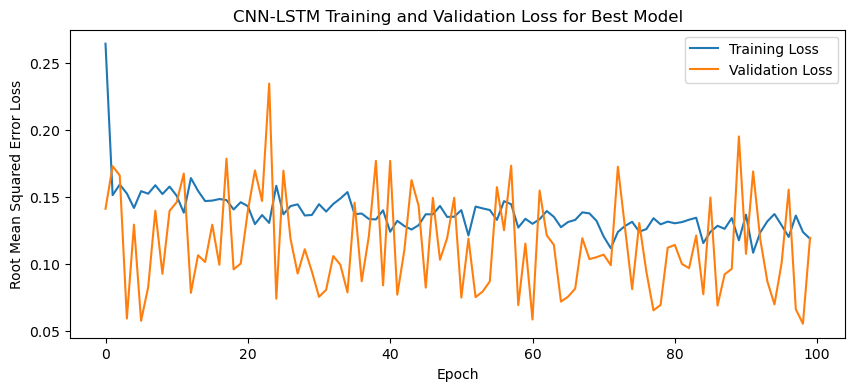

1/1 - 2s - loss: 0.1252 - 2s/epoch - 2s/step
Test Loss: 0.1252116709947586


NameError: name 'make_forecasts' is not defined

In [7]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

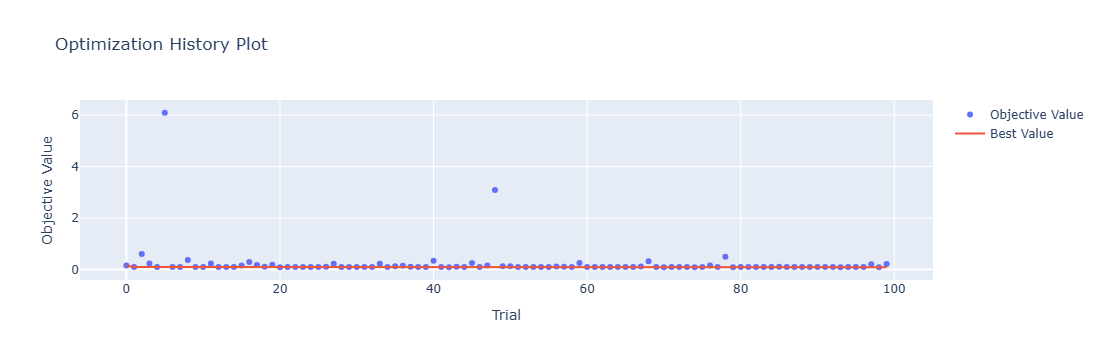

In [8]:
optuna.visualization.plot_optimization_history(study)

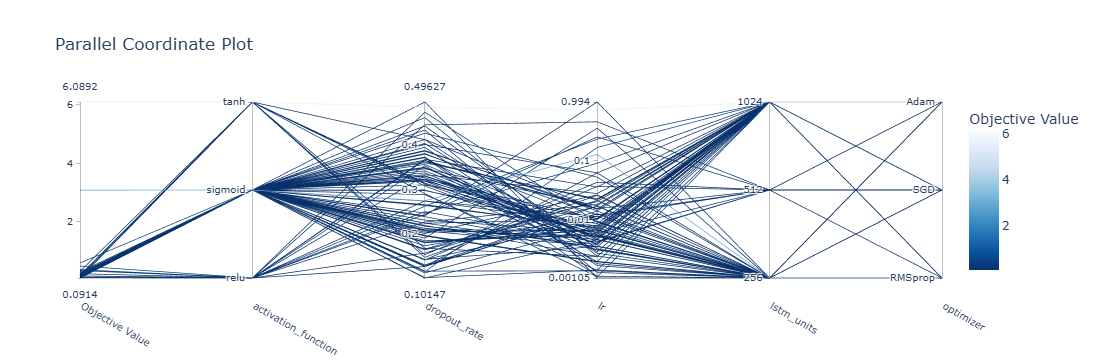

In [9]:
optuna.visualization.plot_parallel_coordinate(study)

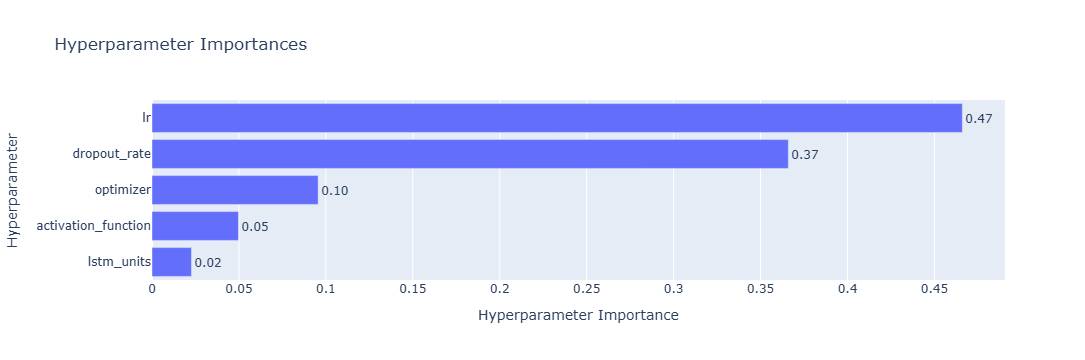

In [10]:
optuna.visualization.plot_param_importances(study)

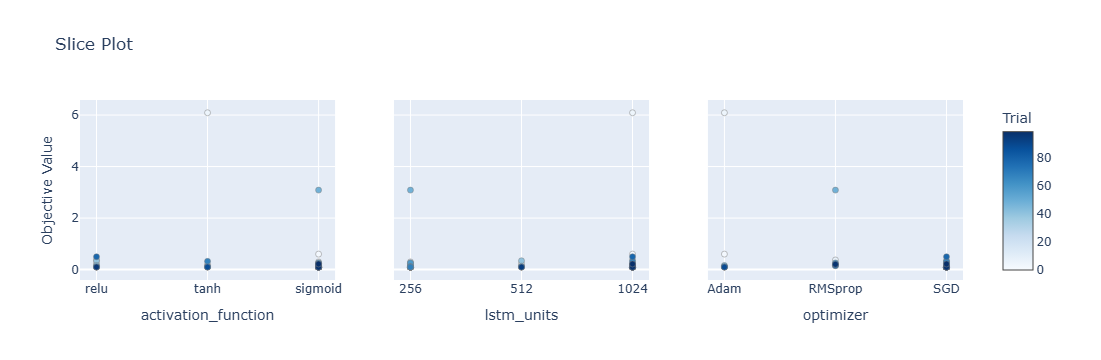

In [11]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

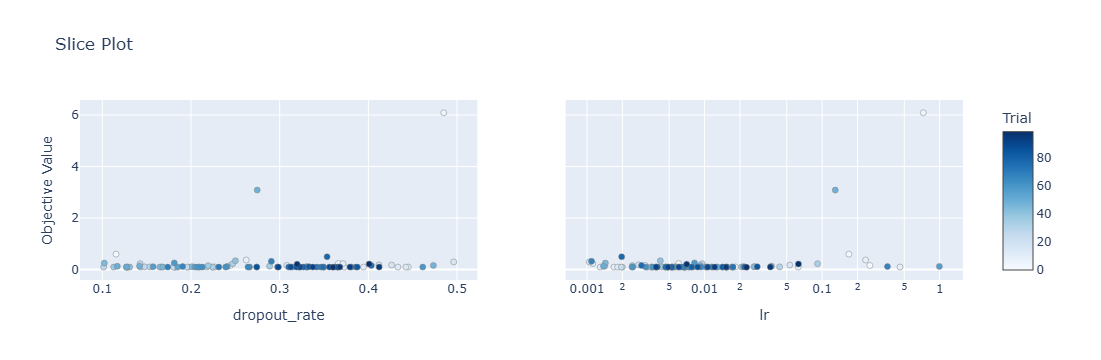

In [12]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
  19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
  21.81 22.23 22.62]
 [16.57 15.99 15.39 15.45 15.98 15.45 15.57 15.59 15.96 16.16 15.83 15.88
  15.64 16.44 17.   15.83 15.63 16.9  17.06 17.3  17.26 18.21 17.38 16.87
  17.15 16.98 18.47]]
Epoch 1/100
19/19 [==============================] - 21s 497ms/step - loss: 0.2385 - accuracy: 0.3684 - mae: 0.1929 - rmse: 0.2385 - mape: 39.1622 - pearson: 0.3024 - val_loss: 0.1752 - val_accuracy: 0.0000e+00 - val_mae: 0.1551 - val_rmse: 0.1752 - val_mape: 28.6481 - val_pearson: 0.2271
Epoch 2/100
19/19 [==============================] - 2s 95ms/step - loss: 0.1603 - accuracy: 0.3684 - mae: 0.1402 - rmse: 0.1603 - mape: 25.6230 - pearson: 0.3859 - val_loss: 0.1904 - val_accuracy: 0.3333 - val_mae: 0.1778 - val_rmse: 0.1904 - val_mape: 34.0389 - val_pearson: 0.0120
Epoch 3/100
19/19 [==============================] - 2s 99ms/step - loss: 0.1565 - accu

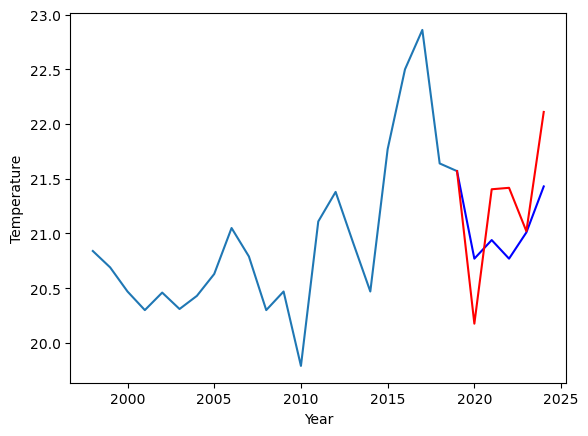

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
17.52		15.91		-1.61
16.69		17.13		0.44
16.18		17.15		0.97
16.46		16.75		0.29
16.29		17.84		1.55


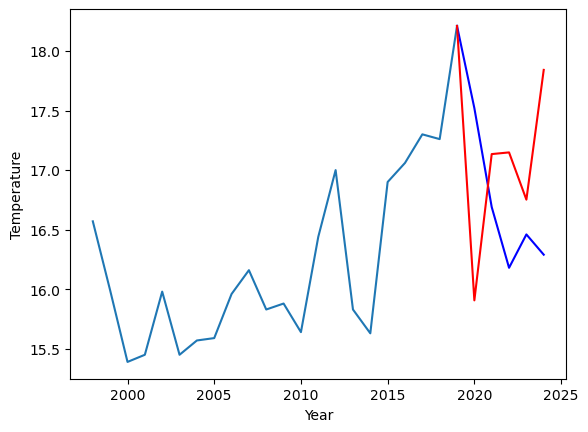

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.77  20.176098
1                1   17.52  15.906666


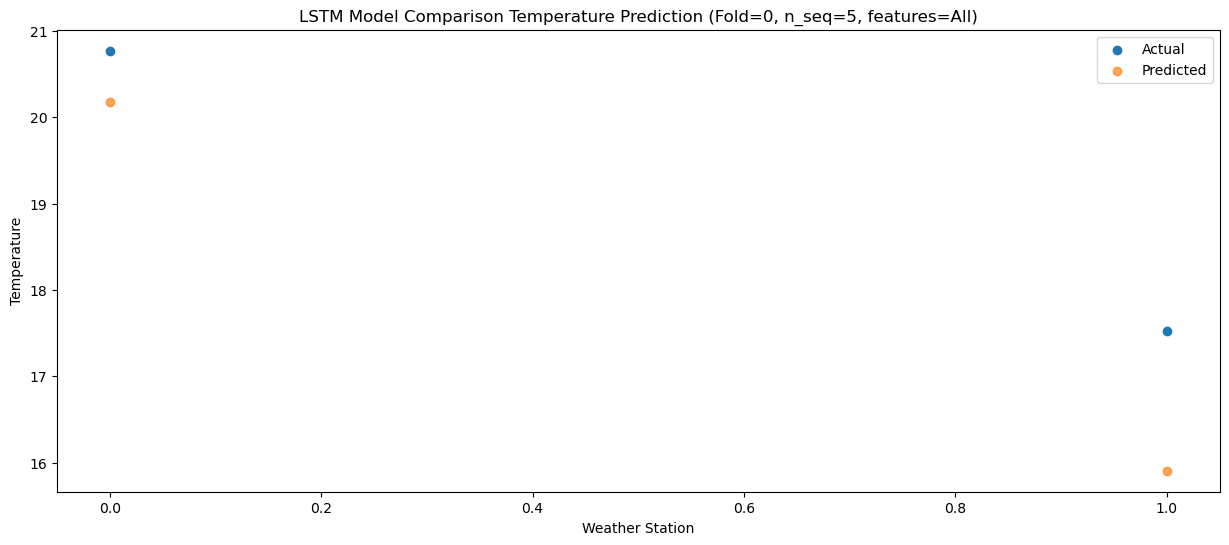

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   20.94  21.404097
1                1   16.69  17.134335


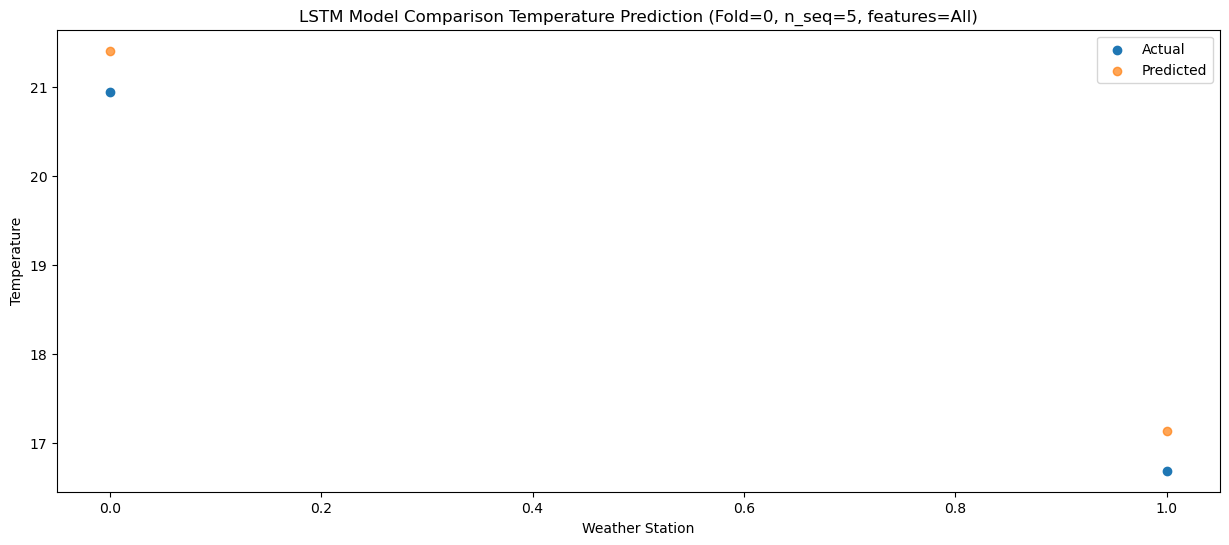

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   20.77  21.417322
1                1   16.18  17.148434


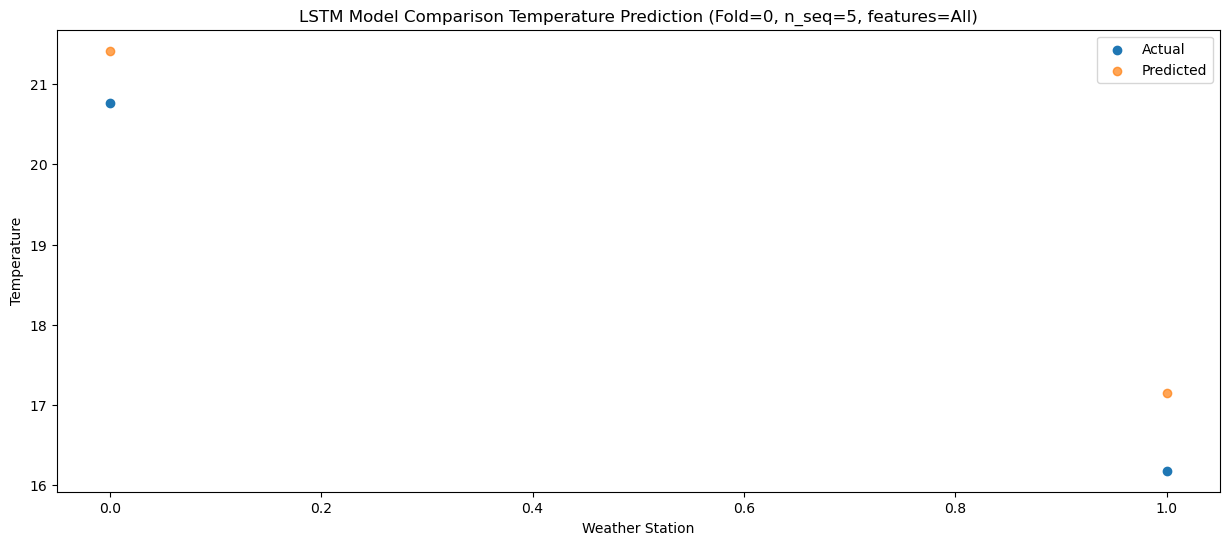

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   21.01  21.020487
1                1   16.46  16.751965


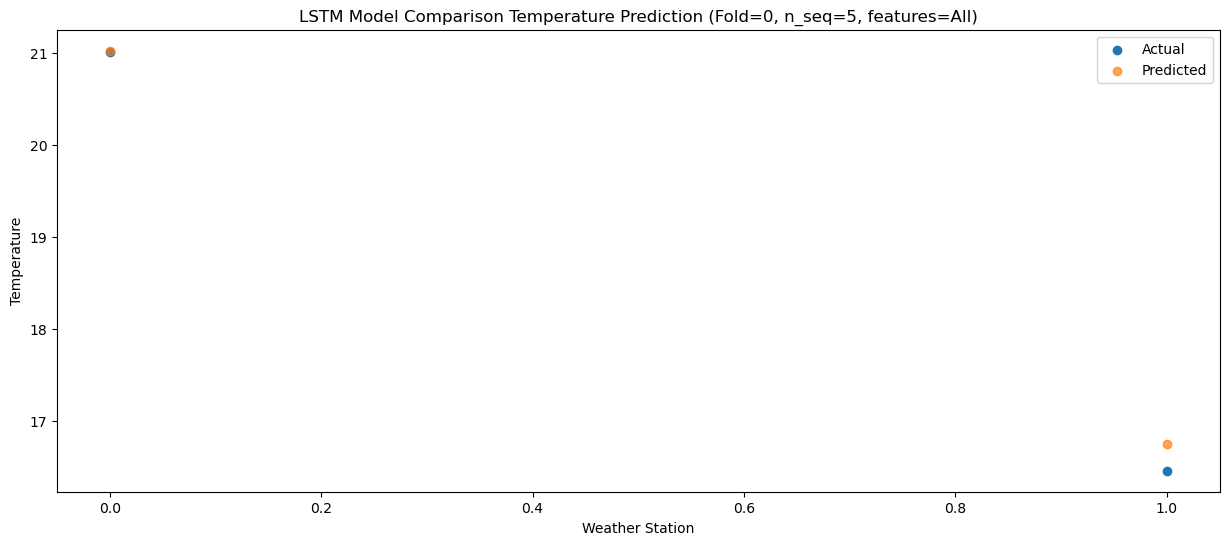

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.43  22.110631
1                1   16.29  17.841044


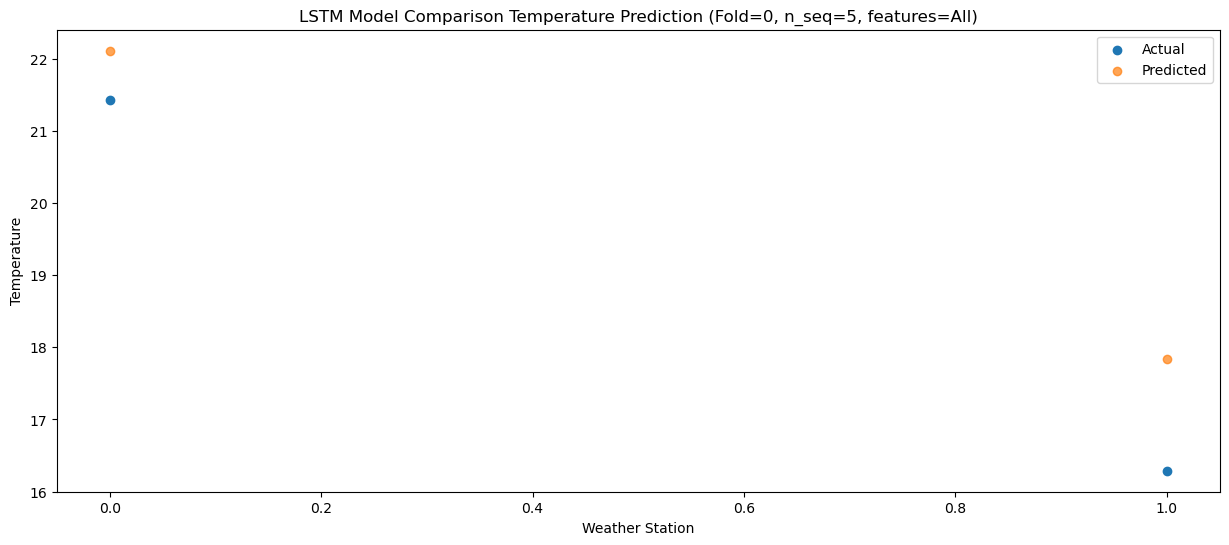

f, t:
[[20.77 17.52]
 [20.94 16.69]
 [20.77 16.18]
 [21.01 16.46]
 [21.43 16.29]]
[[20.17609754 15.90666623]
 [21.40409734 17.13433523]
 [21.41732217 17.14843443]
 [21.02048693 16.75196454]
 [22.11063109 17.84104356]]
Year at t+1:
t+1 SKRMSE: 1.215641
t+1 KRMSE: 1.215641
t+1 MAE: 1.103618
t+1 SKMAPE: 0.060340
t+1 R2_SCORE: 0.440366
t+1 KMAPE: 0.060340
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.454324
t+2 KRMSE: 0.454324
t+2 MAE: 0.454216
t+2 SKMAPE: 0.024393
t+2 R2_SCORE: 0.954290
t+2 KMAPE: 0.024393
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.823678
t+3 KRMSE: 0.823678
t+3 MAE: 0.807878
t+3 SKMAPE: 0.045510
t+3 R2_SCORE: 0.871190
t+3 KMAPE: 0.045510
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.206583
t+4 KRMSE: 0.206583
t+4 MAE: 0.151226
t+4 SKMAPE: 0.009118
t+4 R2_SCORE: 0.991754
t+4 KMAPE: 0.009118
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 1.197705
t+5 KRMSE: 1.197705
t+5 MAE: 1.115837
t+5 SKMAPE: 0.063488
t+5 R2_SCORE: 0.782813
t+5 KMAPE: 0.063488
t+5 PEARSON: 1

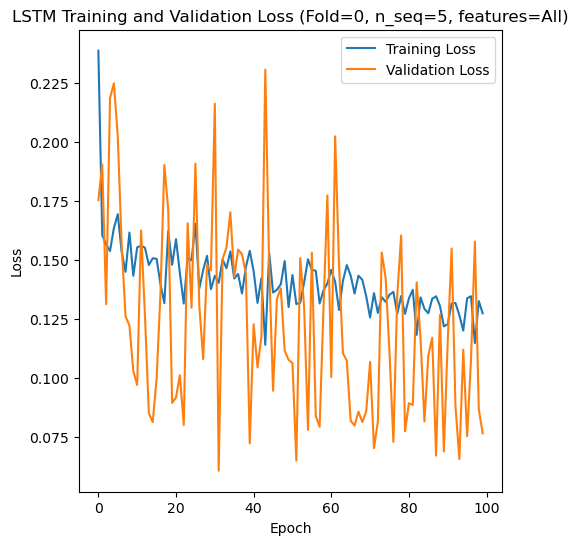

[[19.54 18.69 17.98 18.61 18.9  18.32 18.53 18.52 18.91 19.16 18.59 18.48
  18.2  19.26 19.25 18.86 18.95 19.48 19.77 19.73 19.56 19.64 19.73 18.81
  19.15 19.99 20.79]
 [19.69 19.59 19.68 19.6  19.14 19.33 18.41 19.15 20.48 18.58 19.32 19.44
  18.75 20.43 20.08 18.77 18.96 18.48 19.51 19.89 19.04 19.17 19.69 19.3
  19.3  20.61 21.9 ]]
Epoch 1/100
19/19 [==============================] - 25s 342ms/step - loss: 0.3342 - accuracy: 0.1579 - mae: 0.2958 - rmse: 0.3342 - mape: 50.1016 - pearson: 0.2978 - val_loss: 0.1399 - val_accuracy: 0.0000e+00 - val_mae: 0.1184 - val_rmse: 0.1399 - val_mape: 18.3850 - val_pearson: 0.0430
Epoch 2/100
19/19 [==============================] - 2s 99ms/step - loss: 0.1372 - accuracy: 0.3684 - mae: 0.1155 - rmse: 0.1372 - mape: 18.8332 - pearson: 0.4448 - val_loss: 0.1085 - val_accuracy: 1.0000 - val_mae: 0.0856 - val_rmse: 0.1085 - val_mape: 13.1471 - val_pearson: 0.4743
Epoch 3/100
19/19 [==============================] - 2s 99ms/step - loss: 0.1506 - accur

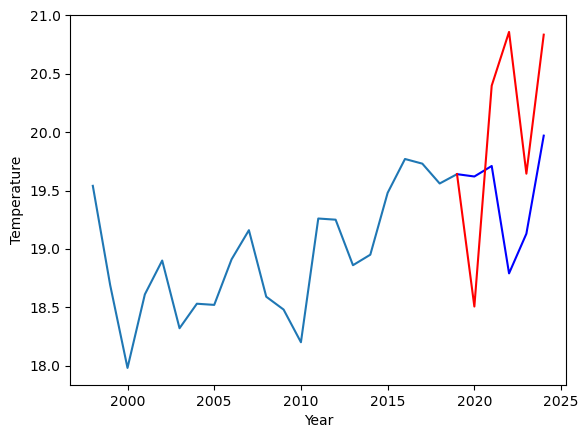

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
19.82		18.66		-1.16
20.34		20.55		0.21
19.95		21.01		1.06
19.95		19.79		-0.16
21.26		20.98		-0.28


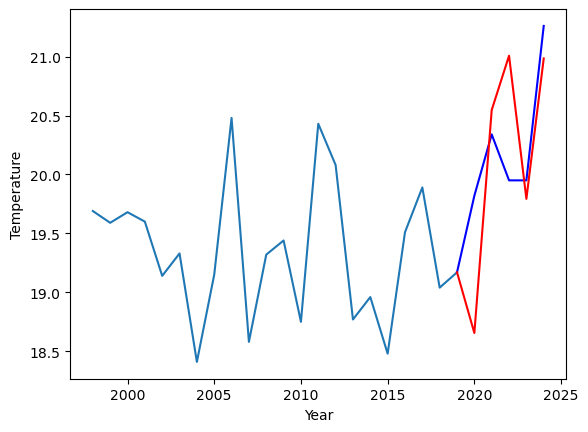

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   19.62  18.505970
1                1   19.82  18.655157


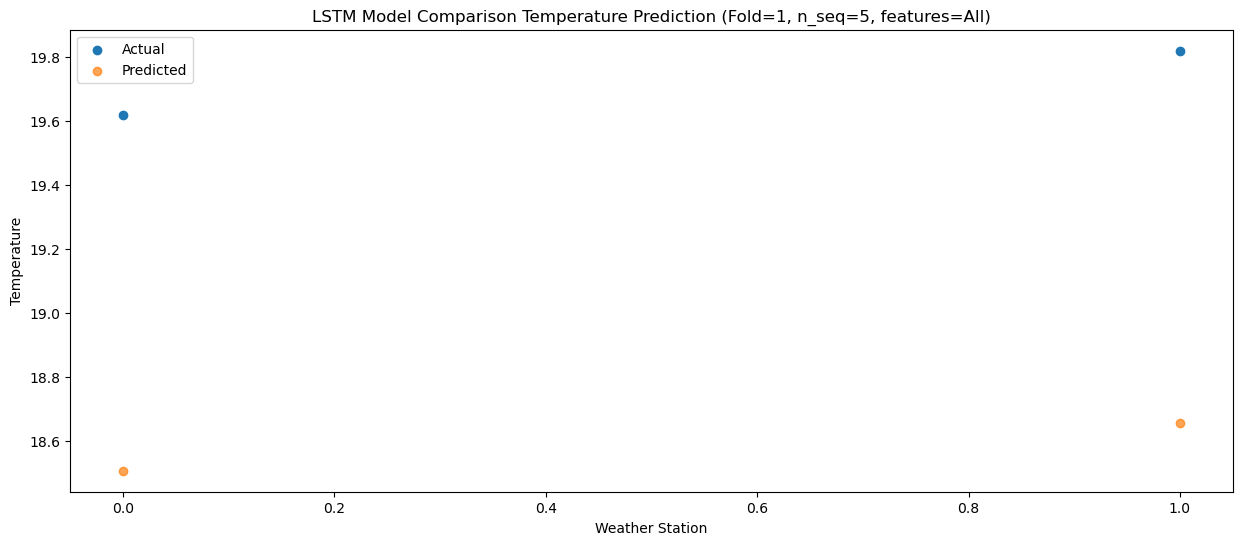

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   19.71  20.398191
1                1   20.34  20.546531


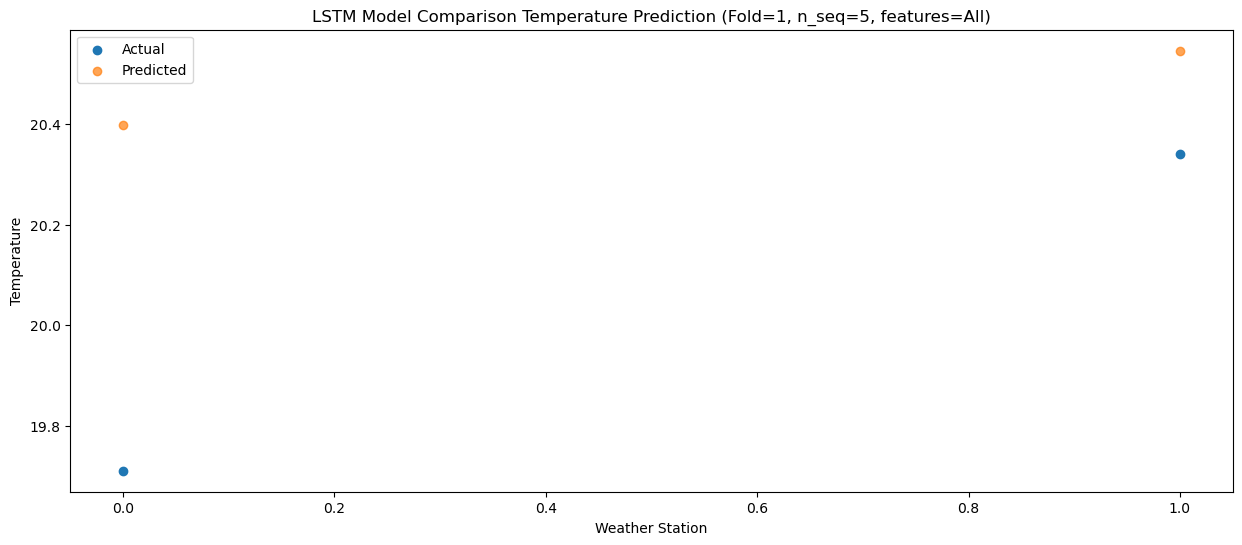

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   18.79  20.858597
1                1   19.95  21.007559


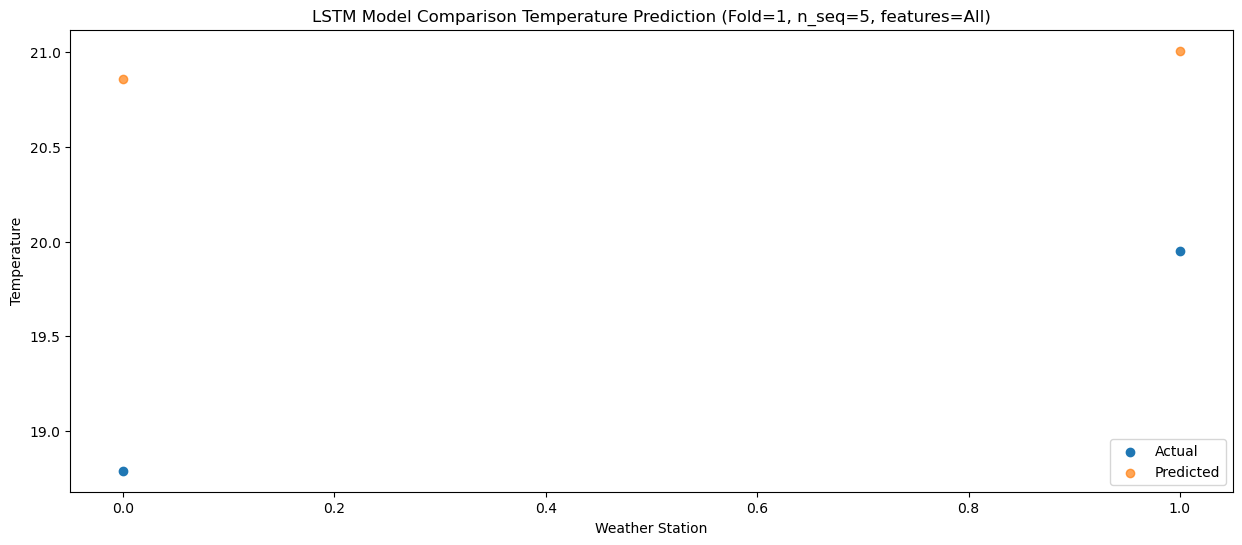

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   19.13  19.644152
1                1   19.95  19.793068


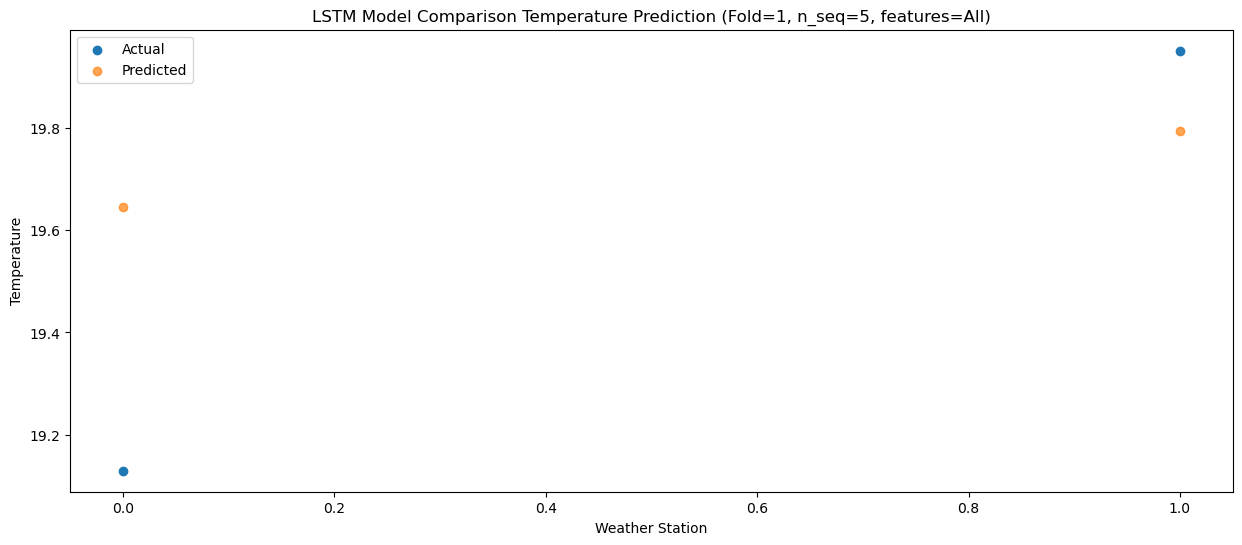

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   19.97  20.835133
1                1   21.26  20.984151


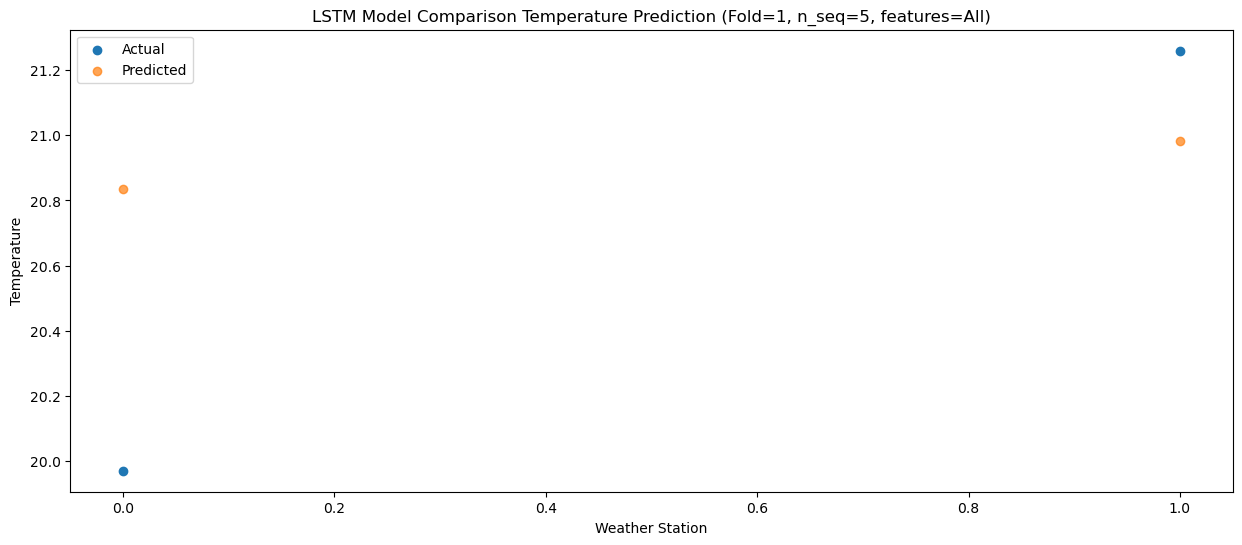

f, t:
[[19.62 19.82]
 [19.71 20.34]
 [18.79 19.95]
 [19.13 19.95]
 [19.97 21.26]]
[[18.50596956 18.65515727]
 [20.39819101 20.54653102]
 [20.8585972  21.00755865]
 [19.64415196 19.79306835]
 [20.83513347 20.98415143]]
Year at t+1:
t+1 SKRMSE: 1.139720
t+1 KRMSE: 1.139720
t+1 MAE: 1.139437
t+1 SKMAPE: 0.057776
t+1 R2_SCORE: -128.896120
t+1 KMAPE: 0.057776
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.508066
t+2 KRMSE: 0.508066
t+2 MAE: 0.447361
t+2 SKMAPE: 0.022535
t+2 R2_SCORE: -1.601471
t+2 KMAPE: 0.022535
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 1.642791
t+3 KRMSE: 1.642791
t+3 MAE: 1.563078
t+3 SKMAPE: 0.081550
t+3 R2_SCORE: -7.022480
t+3 KMAPE: 0.081550
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.380118
t+4 KRMSE: 0.380118
t+4 MAE: 0.335542
t+4 SKMAPE: 0.017371
t+4 R2_SCORE: 0.140453
t+4 KMAPE: 0.017371
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.642086
t+5 KRMSE: 0.642086
t+5 MAE: 0.570491
t+5 SKMAPE: 0.028148
t+5 R2_SCORE: 0.009016
t+5 KMAPE: 0.028148
t+5 PEARS

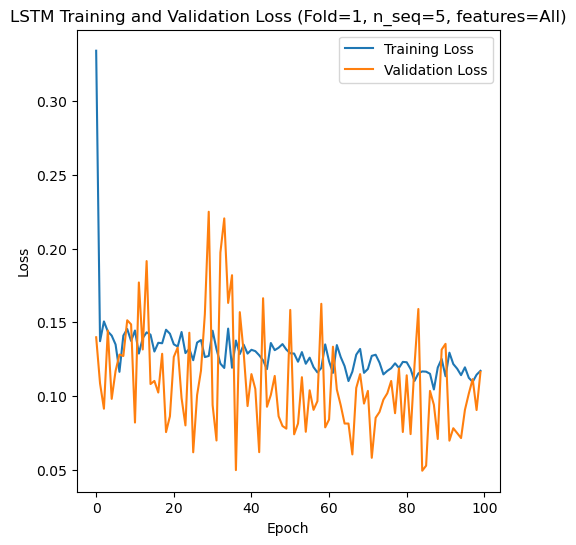

[[16.84 16.42 15.63 15.84 16.01 15.21 15.86 15.86 16.6  17.15 15.61 15.43
  15.69 16.61 16.97 15.29 15.43 16.62 17.18 16.96 16.33 17.09 16.39 16.63
  16.6  17.04 18.25]
 [13.51 12.74 11.83 12.67 12.83 11.71 12.25 12.85 13.05 13.49 12.15 12.07
  12.6  13.05 14.02 12.15 11.53 12.87 13.64 13.46 12.99 13.32 13.31 13.3
  12.84 13.63 15.32]]
Epoch 1/100
19/19 [==============================] - 23s 409ms/step - loss: 0.3047 - accuracy: 0.2632 - mae: 0.2566 - rmse: 0.3047 - mape: 40.3517 - pearson: 0.2930 - val_loss: 0.1458 - val_accuracy: 0.3333 - val_mae: 0.1274 - val_rmse: 0.1458 - val_mape: 20.5444 - val_pearson: 0.5770
Epoch 2/100
19/19 [==============================] - 2s 81ms/step - loss: 0.1485 - accuracy: 0.2632 - mae: 0.1253 - rmse: 0.1485 - mape: 20.5064 - pearson: 0.3495 - val_loss: 0.1582 - val_accuracy: 0.0000e+00 - val_mae: 0.1222 - val_rmse: 0.1582 - val_mape: 21.1562 - val_pearson: 0.0822
Epoch 3/100
19/19 [==============================] - 2s 86ms/step - loss: 0.1466 - accur

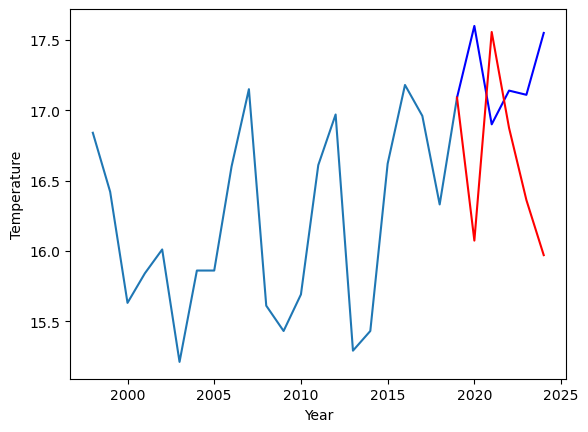

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.84		12.74		-1.10
13.83		14.23		0.40
13.82		13.54		-0.28
13.36		13.03		-0.33
14.15		12.64		-1.51


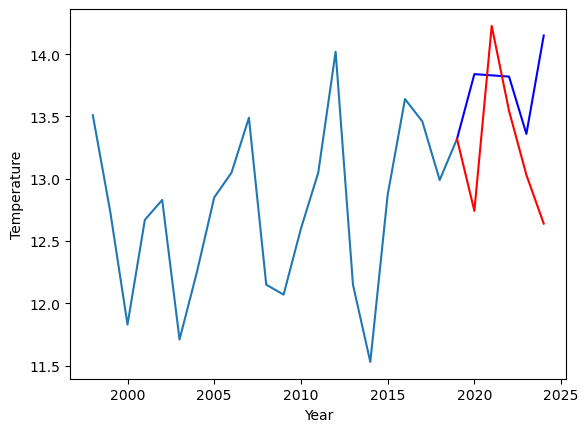

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   17.60  16.072967
1                1   13.84  12.742585


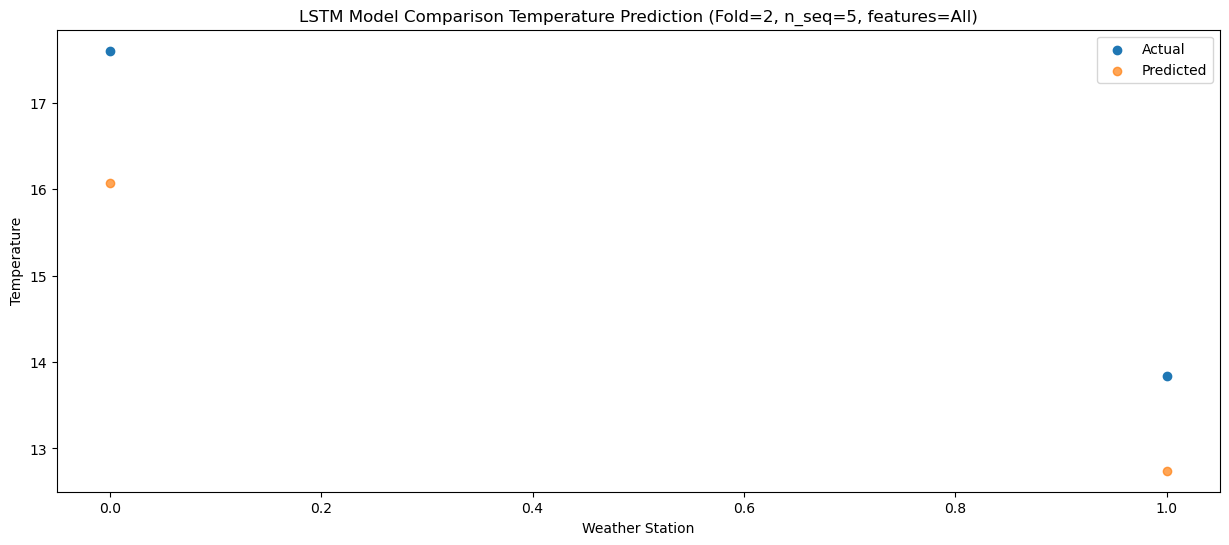

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   16.90  17.556767
1                1   13.83  14.226798


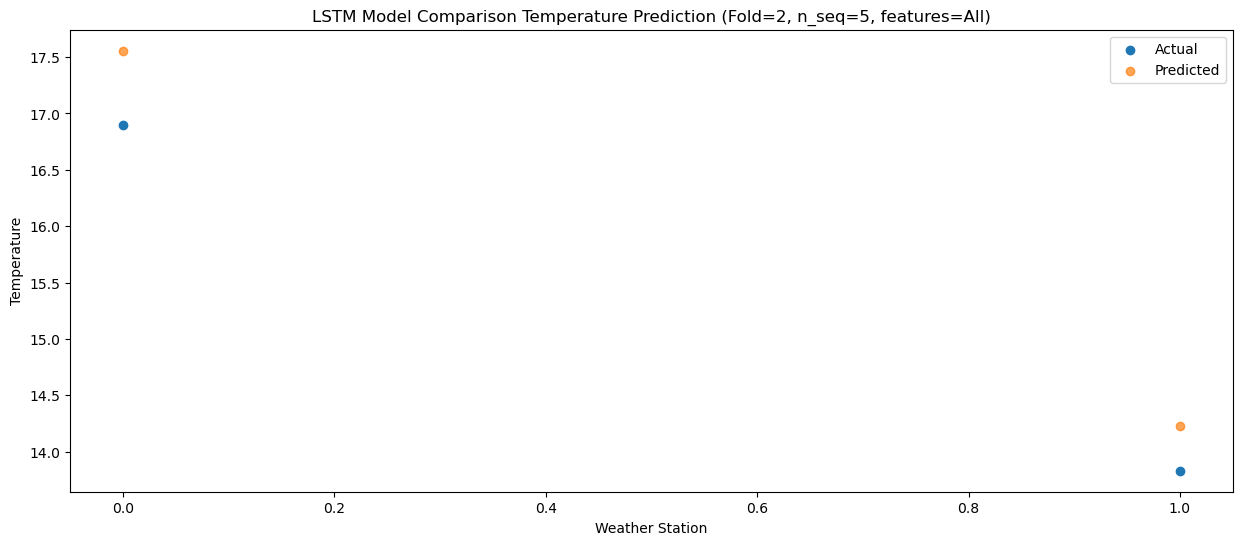

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   17.14  16.874483
1                1   13.82  13.544644


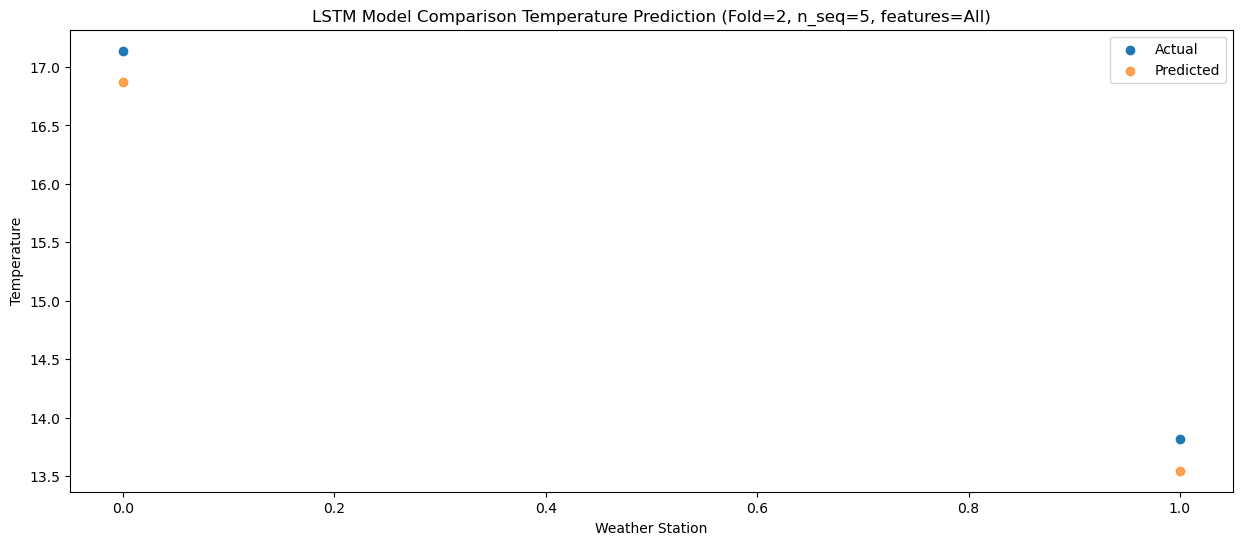

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   17.11  16.361621
1                1   13.36  13.031076


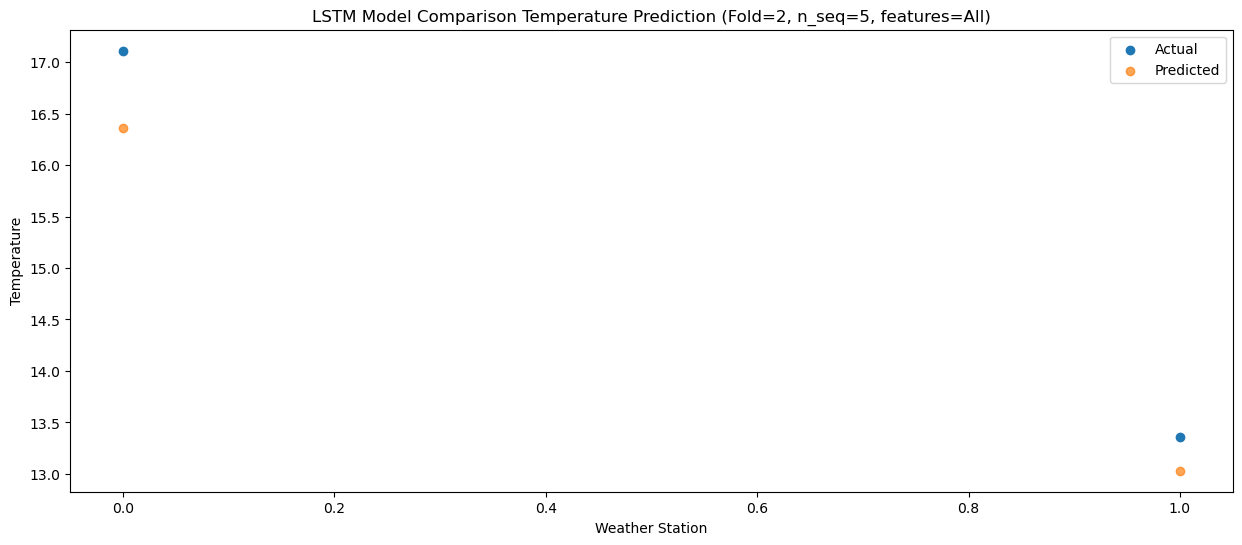

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   17.55  15.969587
1                1   14.15  12.639971


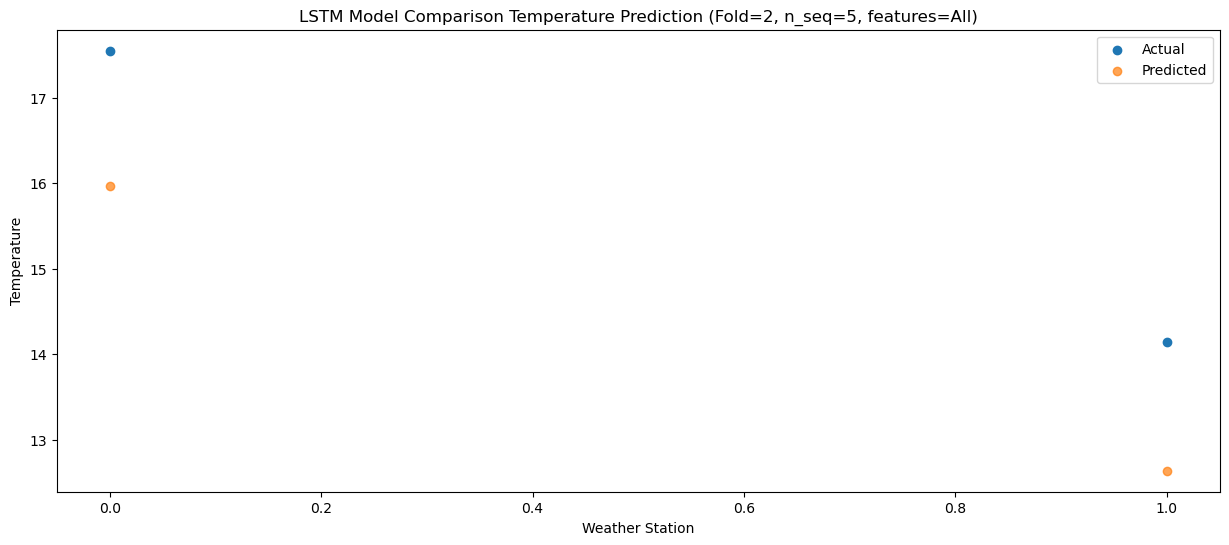

f, t:
[[17.6  13.84]
 [16.9  13.83]
 [17.14 13.82]
 [17.11 13.36]
 [17.55 14.15]]
[[16.07296732 12.74258549]
 [17.55676737 14.22679765]
 [16.87448302 13.54464419]
 [16.36162099 13.03107638]
 [15.96958673 12.63997073]]
Year at t+1:
t+1 SKRMSE: 1.329689
t+1 KRMSE: 1.329689
t+1 MAE: 1.312224
t+1 SKMAPE: 0.083028
t+1 R2_SCORE: 0.499753
t+1 KMAPE: 0.083028
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.542583
t+2 KRMSE: 0.542583
t+2 MAE: 0.526783
t+2 SKMAPE: 0.033777
t+2 R2_SCORE: 0.875056
t+2 KMAPE: 0.033777
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.270481
t+3 KRMSE: 0.270481
t+3 MAE: 0.270436
t+3 SKMAPE: 0.017708
t+3 R2_SCORE: 0.973450
t+3 KMAPE: 0.017708
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.578041
t+4 KRMSE: 0.578041
t+4 MAE: 0.538651
t+4 SKMAPE: 0.034180
t+4 R2_SCORE: 0.904958
t+4 KMAPE: 0.034180
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 1.545622
t+5 KRMSE: 1.545622
t+5 MAE: 1.545221
t+5 SKMAPE: 0.098384
t+5 R2_SCORE: 0.173375
t+5 KMAPE: 0.098384
t+5 PEARSON: 1

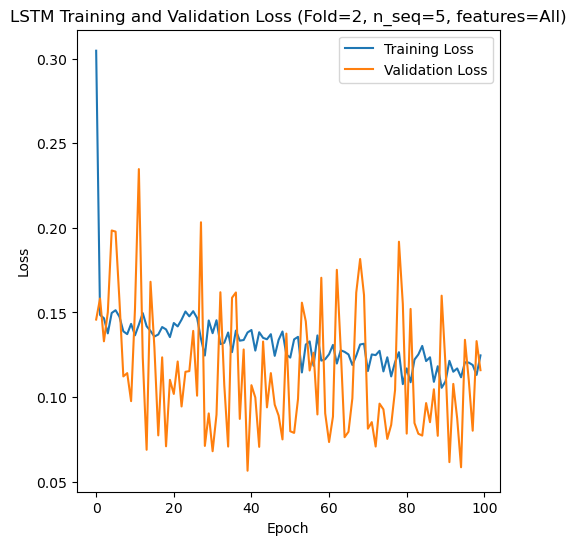

[[14.79 16.53 17.4  17.93 17.46 17.79 17.15 17.27 16.83 16.99 17.41 16.9
  16.66 16.28 17.66 17.63 19.01 18.49 18.19 18.12 18.2  17.83 17.88 18.2
  18.19 17.9  20.04]
 [14.06 13.64 12.62 13.34 13.58 12.56 13.34 13.7  13.71 13.89 12.74 12.51
  12.94 13.34 14.11 12.94 11.91 13.01 14.3  14.13 13.64 14.05 13.93 13.73
  13.43 14.45 16.49]]
Epoch 1/100
20/20 [==============================] - 23s 310ms/step - loss: 0.1920 - accuracy: 0.3500 - mae: 0.1634 - rmse: 0.1920 - mape: 26.3391 - pearson: 0.3285 - val_loss: 0.1138 - val_accuracy: 0.5000 - val_mae: 0.0957 - val_rmse: 0.1138 - val_mape: 15.5466 - val_pearson: 0.6962
Epoch 2/100
20/20 [==============================] - 1s 57ms/step - loss: 0.1414 - accuracy: 0.3500 - mae: 0.1179 - rmse: 0.1414 - mape: 18.6220 - pearson: 0.3419 - val_loss: 0.1140 - val_accuracy: 0.5000 - val_mae: 0.0914 - val_rmse: 0.1140 - val_mape: 13.5844 - val_pearson: 0.6658
Epoch 3/100
20/20 [==============================] - 1s 56ms/step - loss: 0.1363 - accuracy: 

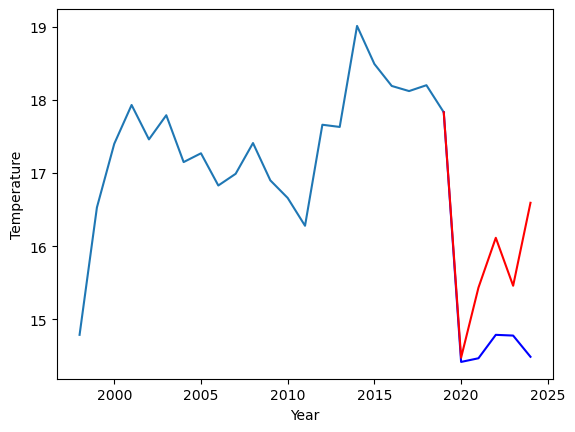

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.47		13.75		-0.72
14.35		14.70		0.35
14.15		15.39		1.24
13.85		14.73		0.88
14.87		15.87		1.00


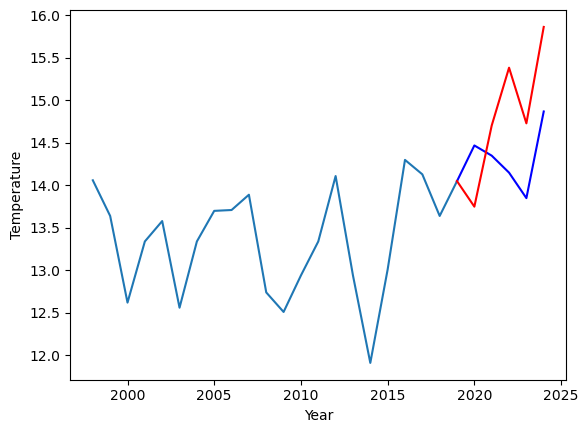

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   14.42  14.478593
1                1   14.47  13.749534


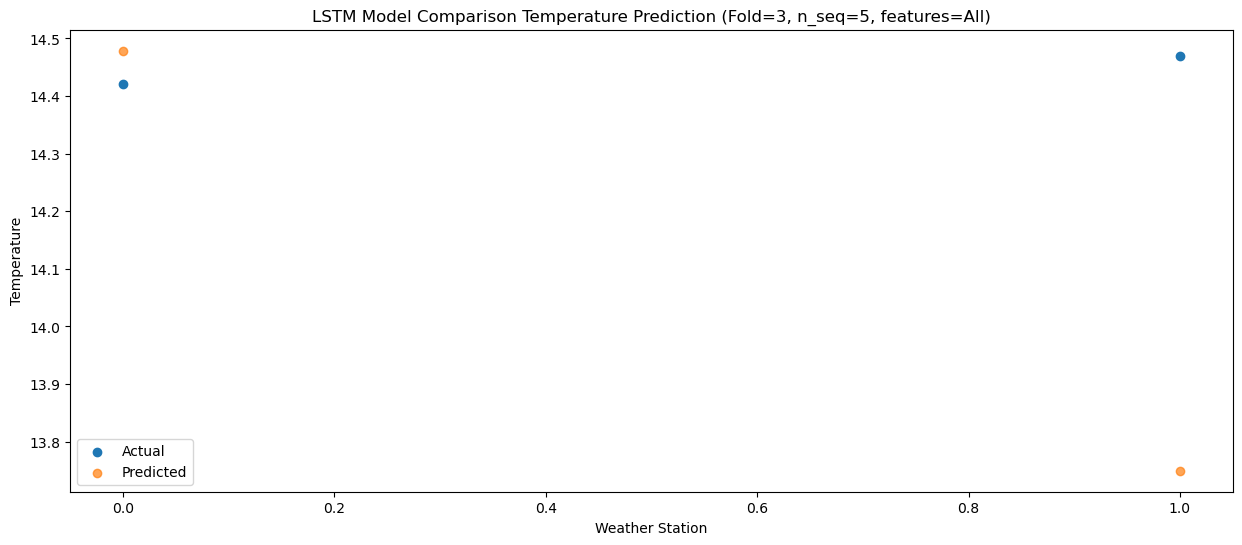

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   14.47  15.434954
1                1   14.35  14.704375


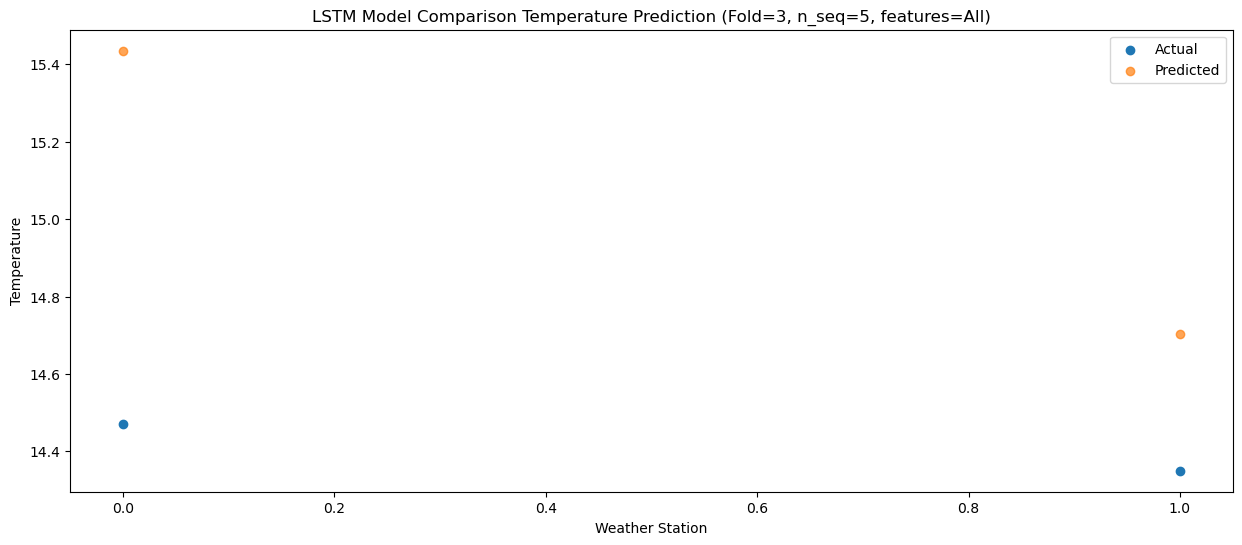

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   14.79  16.115546
1                1   14.15  15.385279


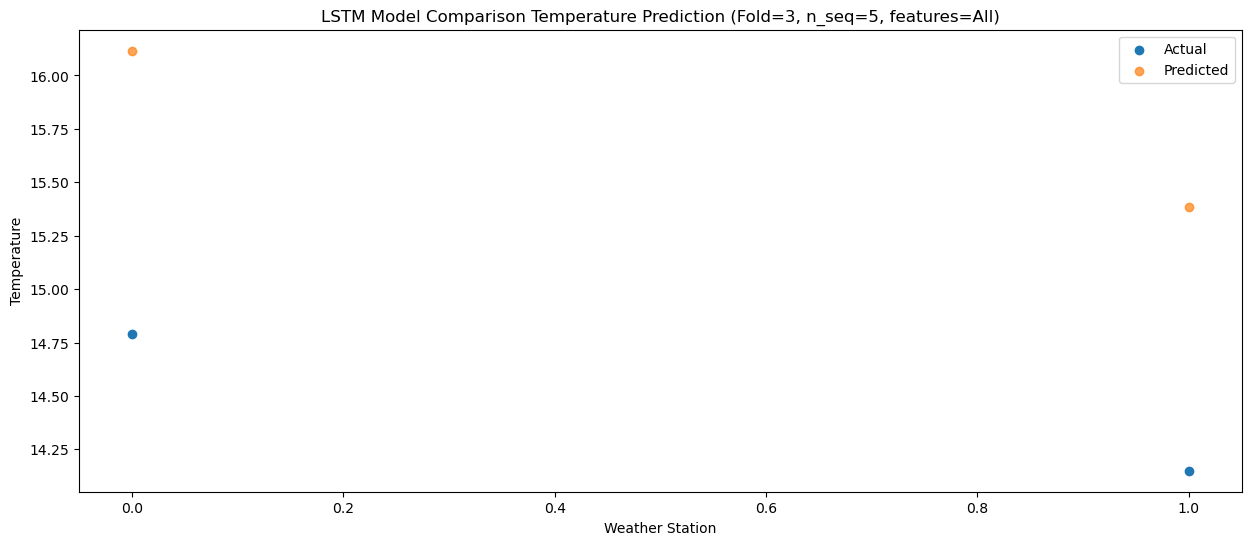

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   14.78  15.460735
1                1   13.85  14.730315


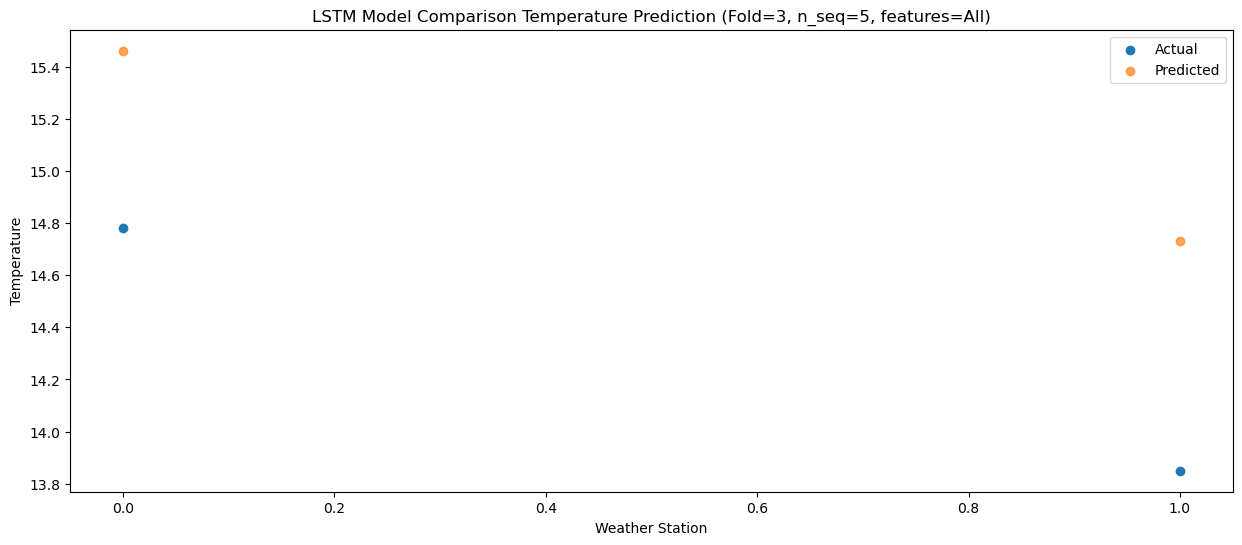

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   14.49  16.593769
1                1   14.87  15.865367


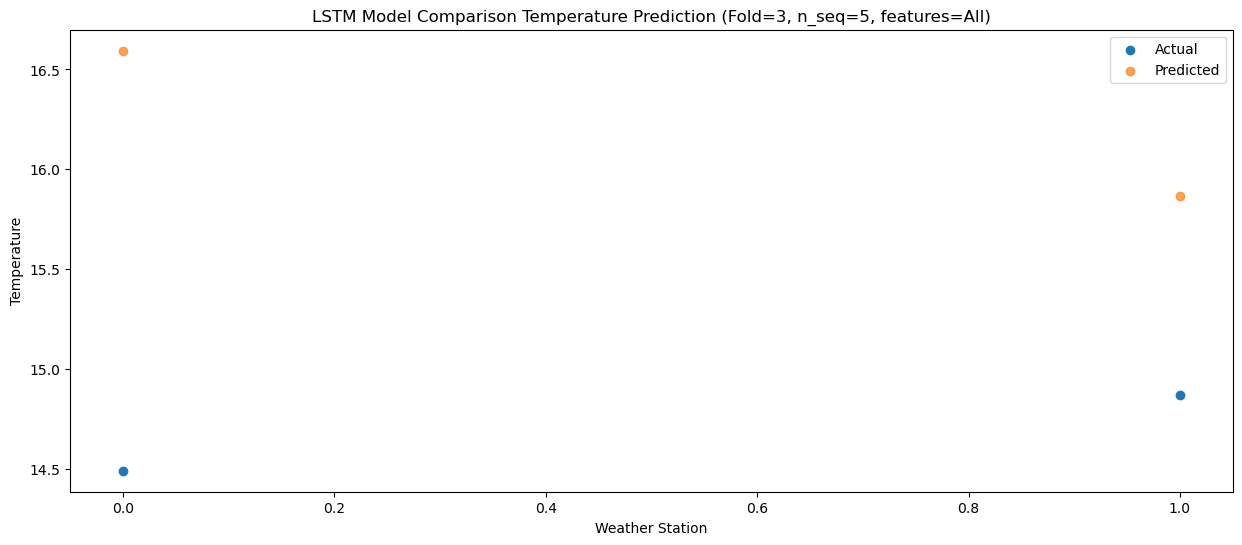

f, t:
[[14.42 14.47]
 [14.47 14.35]
 [14.79 14.15]
 [14.78 13.85]
 [14.49 14.87]]
[[14.47859294 13.74953365]
 [15.43495429 14.70437467]
 [16.1155457  15.38527941]
 [15.46073515 14.73031485]
 [16.59376938 15.86536717]]
Year at t+1:
t+1 SKRMSE: 0.511129
t+1 KRMSE: 0.511129
t+1 MAE: 0.389530
t+1 SKMAPE: 0.026927
t+1 R2_SCORE: -417.003914
t+1 KMAPE: 0.026927
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.726883
t+2 KRMSE: 0.726883
t+2 MAE: 0.659664
t+2 SKMAPE: 0.045691
t+2 R2_SCORE: -145.766416
t+2 KMAPE: 0.045691
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 1.281208
t+3 KRMSE: 1.281208
t+3 MAE: 1.280413
t+3 SKMAPE: 0.088462
t+3 R2_SCORE: -15.030208
t+3 KMAPE: 0.088462
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.786878
t+4 KRMSE: 0.786878
t+4 MAE: 0.780525
t+4 SKMAPE: 0.054809
t+4 R2_SCORE: -1.863579
t+4 KMAPE: 0.054809
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 1.645692
t+5 KRMSE: 1.645692
t+5 MAE: 1.549568
t+5 SKMAPE: 0.106063
t+5 R2_SCORE: -74.022180
t+5 KMAPE: 0.106063
t+5

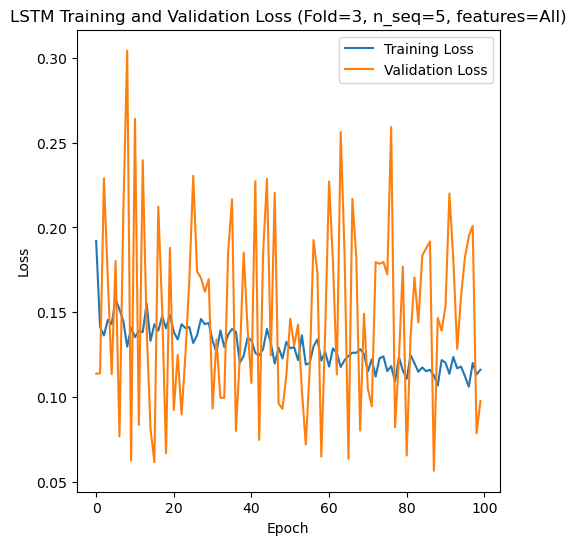

[[21.14 18.96 18.26 17.93 17.59 18.09 18.   18.94 19.77 18.17 18.51 17.84
  17.96 19.05 19.41 17.5  17.5  18.37 18.89 19.09 18.25 18.12 18.64 18.22
  18.72 19.65 20.58]
 [12.93 12.18 11.5  12.1  11.94 11.27 11.81 12.49 12.65 12.57 10.89 11.63
  12.44 12.56 14.1  11.08 10.78 12.73 13.75 13.68 12.38 11.68 12.24 12.56
  11.69 13.17 14.51]]
Epoch 1/100
19/19 [==============================] - 5s 91ms/step - loss: 0.1667 - accuracy: 0.4211 - mae: 0.1469 - rmse: 0.1667 - mape: 23.4292 - pearson: 0.2987 - val_loss: 0.1868 - val_accuracy: 0.0000e+00 - val_mae: 0.1662 - val_rmse: 0.1868 - val_mape: 27.5016 - val_pearson: 0.0547
Epoch 2/100
19/19 [==============================] - 1s 30ms/step - loss: 0.1217 - accuracy: 0.3684 - mae: 0.1021 - rmse: 0.1217 - mape: 16.7570 - pearson: 0.3947 - val_loss: 0.2177 - val_accuracy: 0.0000e+00 - val_mae: 0.1906 - val_rmse: 0.2177 - val_mape: 31.8073 - val_pearson: 0.0157
Epoch 3/100
19/19 [==============================] - 1s 30ms/step - loss: 0.1303 - ac

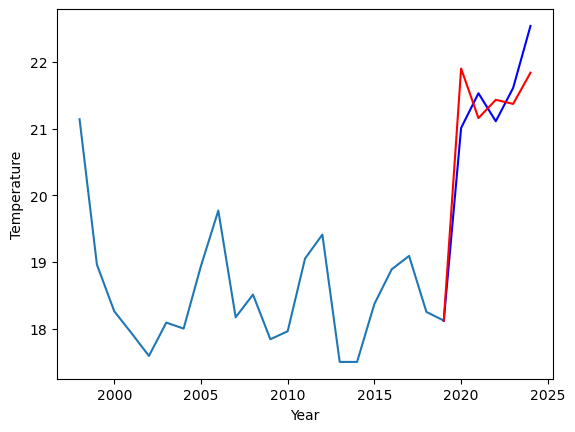

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.23		13.69		1.46
12.79		12.95		0.16
13.11		13.22		0.11
12.24		13.16		0.92
13.72		13.63		-0.09


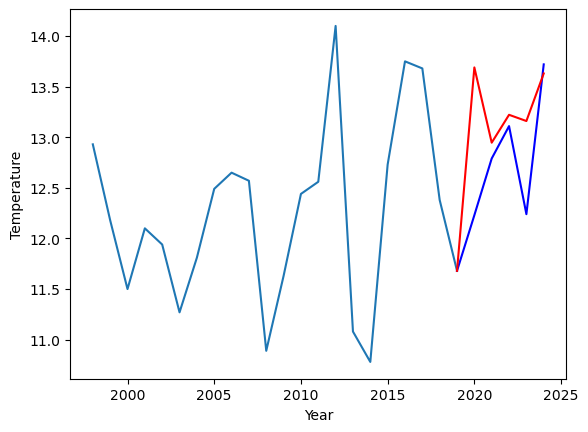

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   21.01  21.901014
1                1   12.23  13.689733


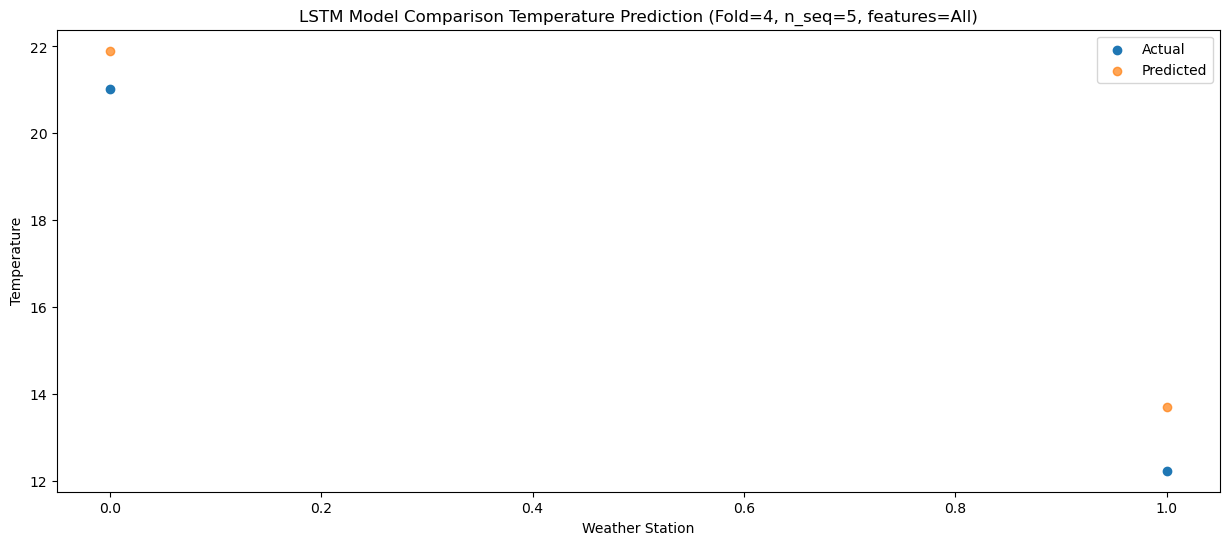

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   21.53  21.157133
1                1   12.79  12.946399


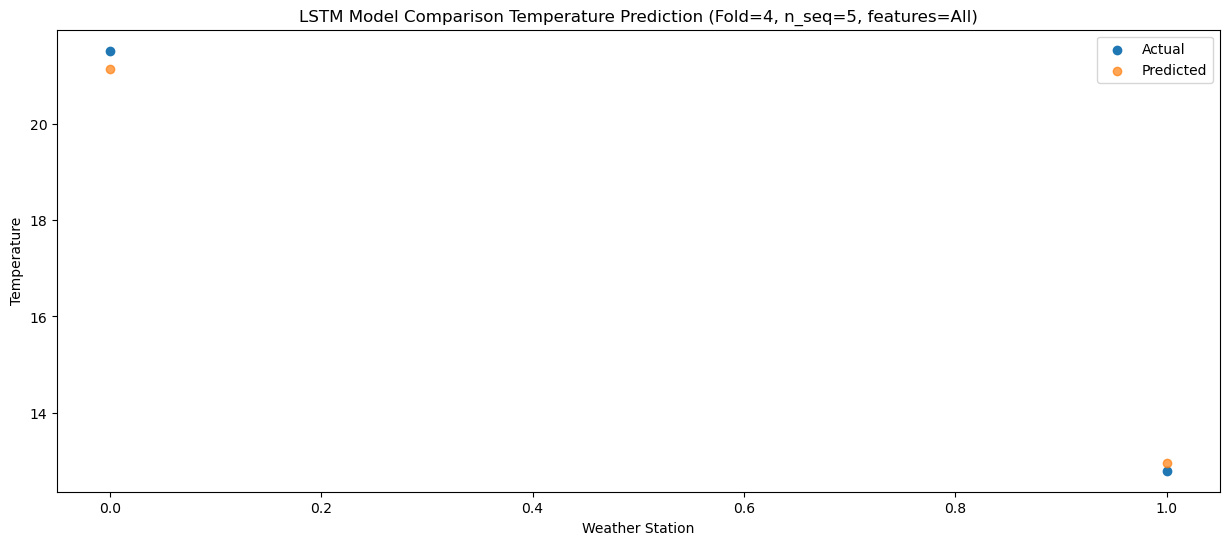

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   21.11  21.431890
1                1   13.11  13.221824


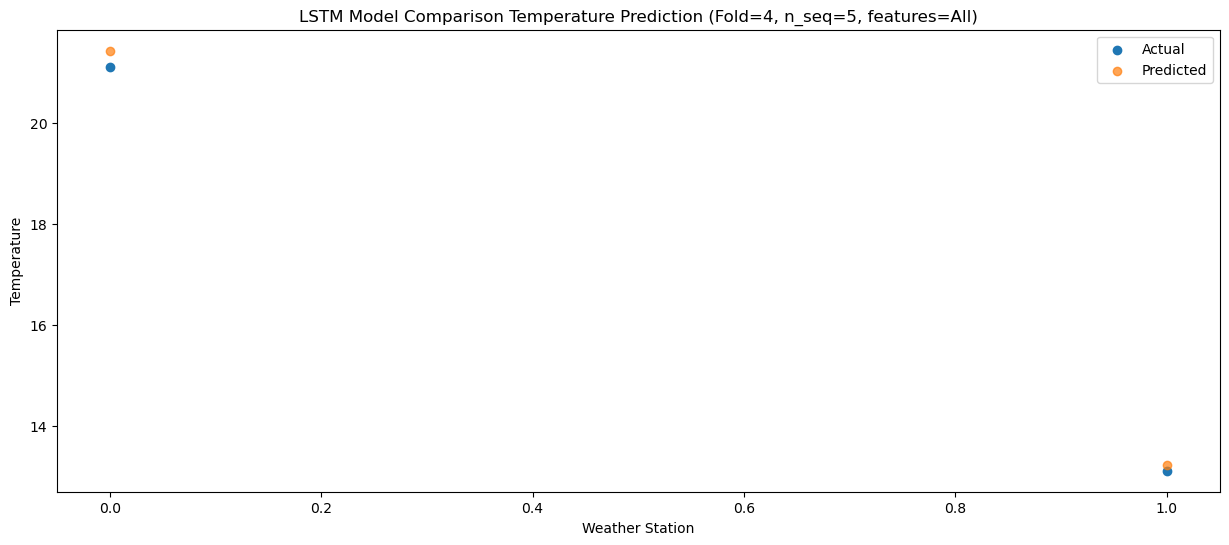

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   21.61  21.370058
1                1   12.24  13.160253


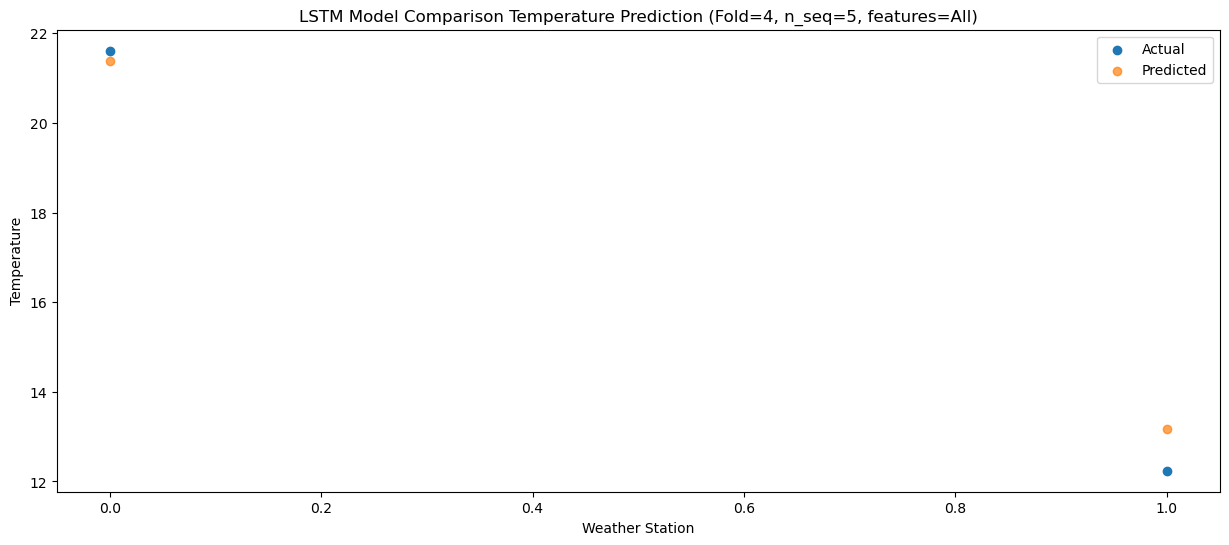

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   22.54  21.838359
1                1   13.72  13.630379


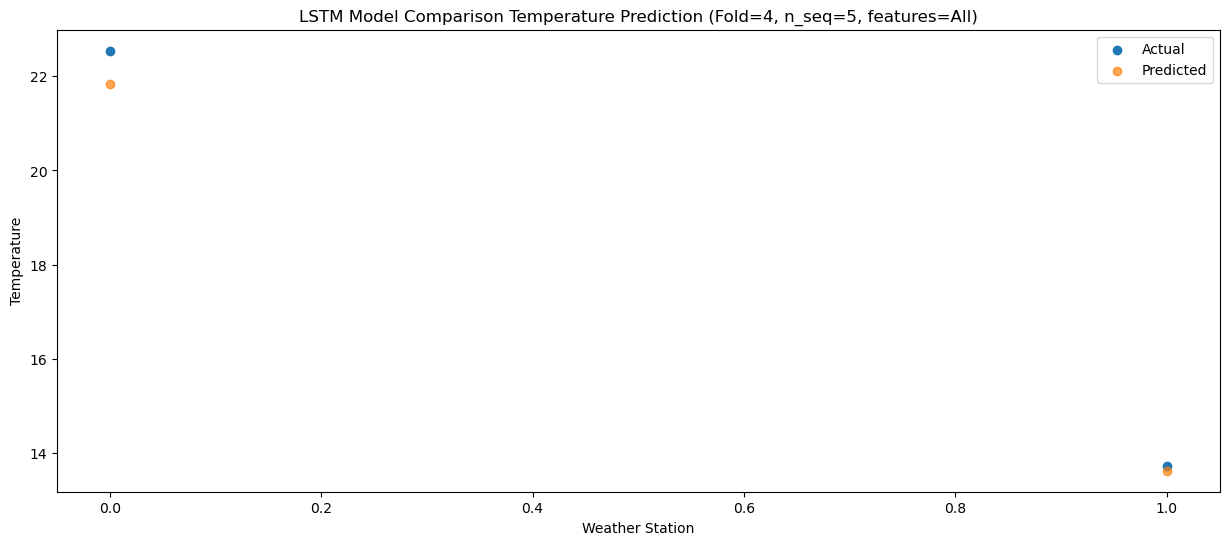

f, t:
[[21.01 12.23]
 [21.53 12.79]
 [21.11 13.11]
 [21.61 12.24]
 [22.54 13.72]]
[[21.9010141  13.68973302]
 [21.15713252 12.94639903]
 [21.43189017 13.22182428]
 [21.37005775 13.16025285]
 [21.8383586  13.63037862]]
Year at t+1:
t+1 SKRMSE: 1.209282
t+1 KRMSE: 1.209282
t+1 MAE: 1.175374
t+1 SKMAPE: 0.080883
t+1 R2_SCORE: 0.924120
t+1 KMAPE: 0.080883
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.285912
t+2 KRMSE: 0.285912
t+2 MAE: 0.264633
t+2 SKMAPE: 0.014773
t+2 R2_SCORE: 0.995719
t+2 KMAPE: 0.014773
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.240954
t+3 KRMSE: 0.240954
t+3 MAE: 0.216857
t+3 SKMAPE: 0.011889
t+3 R2_SCORE: 0.996371
t+3 KMAPE: 0.011889
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.672472
t+4 KRMSE: 0.672472
t+4 MAE: 0.580098
t+4 SKMAPE: 0.043144
t+4 R2_SCORE: 0.979397
t+4 KMAPE: 0.043144
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.500166
t+5 KRMSE: 0.500166
t+5 MAE: 0.395631
t+5 SKMAPE: 0.018830
t+5 R2_SCORE: 0.987137
t+5 KMAPE: 0.018830
t+5 PEARSON: 1

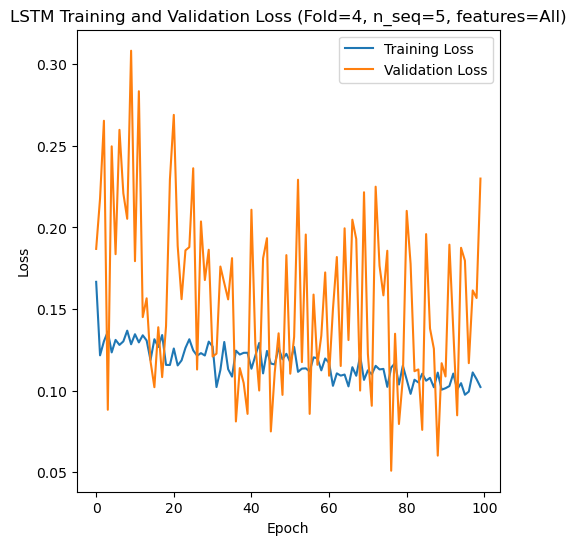

[[0.8763347202864095], [0.9810829289544636], [0.9857695305697789], [1.0731805862361237], [0.6789039436656237]]
[[array(0.87633472)], [array(0.98108293)], [array(0.98576953)], [array(1.07318059)], [array(0.67890394)]]
[[0.7265551504679035], [0.8111816706657411], [0.8386630185842519], [0.9319399915933613], [0.5265185979604722]]
[[0.0405697637772985], [0.041476161598255804], [0.05341519437246591], [0.06439027674804029], [0.03390387033971255]]
[[0.8428645266596076], [-1.4197145020560562], [0.6825846935736484], [-12.357262139011299], [0.9762545374496239]]
[[array(0.04056976)], [array(0.04147616)], [array(0.05341519)], [array(0.06439028)], [array(0.03390387)]]
[[array(0.86538142)], [array(0.07177405)], [array(0.82185106)], [array(0.17938062)], [array(0.98264816)]]
[[[20.176097538471222, 21.404097344875336, 21.417322165481746, 21.020486927740276, 22.110631085149944], [15.906666226387024, 17.134335227012635, 17.14843442633748, 16.75196453526616, 17.841043557673693]], [[18.505969562530517, 20.3

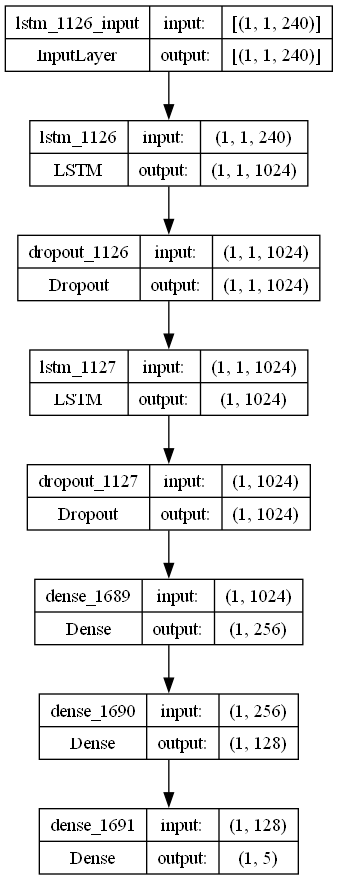

In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.02276362633322624
    optimizer = SGD(learning_rate = lr)
    activation_function = 'sigmoid'
    lstm_units = 1024
    dropout_rate = 0.3600185463105296

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)                        
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(np.mean(pearson_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_CV_S5.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)